# Consider Geology ID for all CPT locations and Visualise

In [6]:
#version = "20210901_1951" # max_depth < 20, which kept 7626 values only. Then applied Vs min cap for z<3m
#version = "zmax_5m" # original version, cutoff at 5m with dup filtering. No Vs min cap applied
version ="zmax_20m_vs_cap"

In [7]:

SHARED="/data/sharing/QuakeCoRE"

import sys
sys.path.append(f"{SHARED}/qcore")
sys.path.append(f"{SHARED}/Vs30")

import numpy as np
import os.path
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

from qcore import geo
from vs30 import model, model_geology,sites_cluster

geo_ids={#0: ("G00","Water"),
         1: ("G01","Peat"),
         2: ("G04","Artificial fill"),
         3: ("G05","Fluvial and esturarine deposits"),
         4: ("G06","Alluvium and valley sediments"),
         5: ("G08","Lacustrine"),
         6: ("G09", "Beach, bar, dune deposits"),
         7: ("G10", "Fan deposits"),
         8: ("G11", "Loess"),
         9: ("G12", "Glacigenic sediments"),
         10: ("G13", "Flood deposits"),
         11: ("G14", "Glacial moraines and till"),
         12: ("G15", "Undifferentiated sediments and sedimentary rocks"),
         13: ("G16", "Terrace deposits and old alluvium"),
         14: ("G17", "Volcanic rocks and deposits"),
         15: ("G18", "Crystalline rocks"),
        }


HOME = Path(os.path.expanduser("~"))
outdir = HOME / f"Data/cpt/outdir/{version}"

if not outdir.exists():
    outdir.mkdir(parents=True)

    
model_ids_csv_file=outdir / f"model_ids.csv"
vs30_results=outdir / f"vs30_results.csv"
assert vs30_results.exists(), f"{vs30_results} not found"
vs30_df=pd.read_csv(vs30_results,index_col=0)
points=vs30_df[['NZTM_X','NZTM_Y']].values



def __padding(n):
    if n==3:
        return [8,5,2]
    elif n==4:
        return [8,6,4,2]
    

def plot_vs30_for_all_geo_ids(data_dict):
    #data_dict = {legend : [mean,error,marker,colour],...}
    
    geo_id_codes= [x for x,_ in geo_ids.values()] # (G01, G04 ....)

    fig,ax=plt.subplots()
    ax.set_xlabel("Geology Categories")
    ax.set_ylabel("Vs30 (m/s)")
    #ax.yaxis.grid(True)

    ax.set_yscale('log')
    ax.set_ylim([100,2000])
    yticks=[100,200,300,400,500,600,800,1000,2000]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)

    #customizing xtick labels
    geo_id_values = np.array([(i)*10 for i in range(len(geo_ids))]) 
    ax.set_xticks(geo_id_values)
    ax.set_xticklabels(geo_id_codes,fontdict={'horizontalalignment':'right'})

    error_bars =[]
    padding = __padding(len(data_dict)) #used to shift the errorbar left
    
    for i,key in enumerate(data_dict.keys()):
        mean,error,marker,color = data_dict[key]
        error_bars.append(ax.errorbar(geo_id_values-padding[i],mean, error,linestyle="None",marker=marker,color=color))
    

    ax.grid()

    ax.legend(error_bars,data_dict.keys(),loc=2)


    plt.tight_layout()
    plt.show()

def dist_x_range(mean,std,n_bins):
    return np.linspace(mean-3*std,mean+3*std,n_bins)


def __plot_hist_dist(vs30_data,n_bins,data_dict,id):
    # data_dict = {legend: [means,errors,colour],...}
    # where, means and errors for id (eg.  4: ("G06","Alluvium and valley sediments"), id is 4. id = 1...15)
    # are accessed by means[id-1] errors[id-1]
    
    plt.rcParams['figure.figsize'] = [8, 5]


    fig,ax=plt.subplots()
    ax.set_xlabel("Vs30 (m/s)")
    ax.set_ylabel("Probability")

    new_p=ax.hist(vs30_data,bins=n_bins, density=True,color="blue",label="Data(McGann15 rel)")
    
    gid,description = geo_ids[id]

    for i,key in enumerate(data_dict.keys()):
        mean,error,color=data_dict[key]
        x=dist_x_range(mean[id-1],error[id-1],n_bins)
        ax.plot(x,stats.norm.pdf(x,mean[id-1],error[id-1]),color=color,label=key)
    
    ax.legend(loc=2)
    ax.set_title("{}: {}".format(gid,description))
    
    plt.show()
    fig.savefig(outdir/'{}.png'.format(gid))    

def plot_hist_dist(data_dict,id):
    

    __plot_hist_dist(vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']==id].Vs30, 50, data_dict,id)
    


For a given location, we can get a model_id like this

In [8]:
print(model_geology.model_id(np.array([[1759275.267087352],[5903767.814975549]]).T))

[12]


In [9]:
vs30_df

NZTM_X        NZTM_Y         Vsz        Vs30  Zmax  Zmin  \
CPT_1         1.576467e+06  5.181262e+06  210.512137  227.536512    25  0.04   
CPT_10001     1.570257e+06  5.178666e+06  147.944481  164.045386    23  0.00   
CPT_10003     1.571621e+06  5.179830e+06  179.581477  187.277570    27  0.00   
CPT_10004     1.571595e+06  5.179847e+06  183.241755  191.155068    27  0.00   
CPT_10005     1.570682e+06  5.180753e+06  152.126549  180.488281    20  0.40   
...                    ...           ...         ...         ...   ...   ...   
SCPT_TT95352  1.746063e+06  5.969807e+06  127.014493  143.107875    22  0.01   
SCPT_TT95395  1.746175e+06  5.969737e+06  122.926809  138.253939    22  0.01   
SCPT_TT95397  1.746216e+06  5.969665e+06  124.950446  137.485455    23  0.06   
SCPT_TT95534  1.884410e+06  5.824483e+06  103.600474  111.363323    24  3.91   
SCPT_TT95535  1.884402e+06  5.824439e+06  146.971739  157.440407    25  1.97   

              Zspan  
CPT_1         25.92  
CPT_10001     23.34  
CPT_10003     27.30  
CPT_10004     27.24  
CPT_10005     19.66  
...             ...  
SCPT_TT95352  22.10  
SCPT_TT95395  22.60  
SCPT_TT95397  23.38  
SCPT_TT95534  20.76  
SCPT_TT95535  23.56  

[7626 rows x 7 columns]

The following works out model_ids for all locations. Can take some time. If the CSV file exists, it will just load the file instead.

In [10]:
if model_ids_csv_file.exists():
    model_ids=np.loadtxt(model_ids_csv_file)
else:
    model_ids=model_geology.model_id(points)
    np.savetxt(model_ids_csv_file,model_ids)



## Combine Vs30 estimates with Geological category ID
Add model_ids to vs30_df, and remove records whose id == 255 (meaning no data. 204 such records found) and id == 0 (Water)

In [11]:
plt.rcParams['figure.dpi']=150
plt.rcParams["figure.figsize"] = (3,2)

vs30_geo_id_df=vs30_df.copy() 
vs30_geo_id_df['geo_model_idx']=model_ids
vs30_geo_id_df=vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']!=255] #remove 255 = ID_NODATA
vs30_geo_id_df=vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']!=0] #remove 0 = Water

plt.hist(vs30_geo_id_df.geo_model_idx,bins=20)

plt.show()

### Summaries for each category

In [12]:
# for i,(gid,geo_name) in geo_ids.items():
#     print(gid, geo_name)
#     print(vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']==i].describe())

## Means and Errors for each category

In [13]:
means = []
errors = []
for i,(gid,geo_name) in geo_ids.items():
    print(gid, geo_name)
    count = vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']==i].Vs30.count()
    vs30_mean= vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']==i].Vs30.mean()
    vs30_std = vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']==i].Vs30.std()
    print("n = {} vs30={} std= {}".format(count, vs30_mean, vs30_std))

    means.append(vs30_mean)
    errors.append(vs30_std)



G01 Peat
n = 276 vs30=164.48314496405777 std= 30.945256514189968
G04 Artificial fill
n = 101 vs30=137.11246366255375 std= 27.72890918826672
G05 Fluvial and esturarine deposits
n = 349 vs30=191.08671475942174 std= 28.96055567104092
G06 Alluvium and valley sediments
n = 1071 vs30=155.56819231848974 std= 29.756350331400384
G08 Lacustrine
n = 26 vs30=162.38009889486597 std= 19.955559594849642
G09 Beach, bar, dune deposits
n = 2462 vs30=204.45826790192703 std= 19.79328550002987
G10 Fan deposits
n = 39 vs30=180.98853086506068 std= 32.49773523323355
G11 Loess
n = 46 vs30=165.10123513929503 std= 19.847167102680196
G12 Glacigenic sediments
n = 1 vs30=165.09239945237906 std= nan
G13 Flood deposits
n = 2034 vs30=185.20716084453386 std= 24.976132948654676
G14 Glacial moraines and till
n = 6 vs30=161.59320329948847 std= 26.57703760326517
G15 Undifferentiated sediments and sedimentary rocks
n = 687 vs30=157.24865225971058 std= 24.970786911848464
G16 Terrace deposits and old alluvium
n = 191 vs30=146

### Get prior model and posterior models

In [14]:
prior=model_geology.model_prior()
prior_means=prior.T[0]
prior_errors=prior.T[1]*prior_means

posterior = model_geology.model_posterior_paper()
posterior_means = posterior.T[0]
posterior_errors = posterior.T[1]*posterior_means

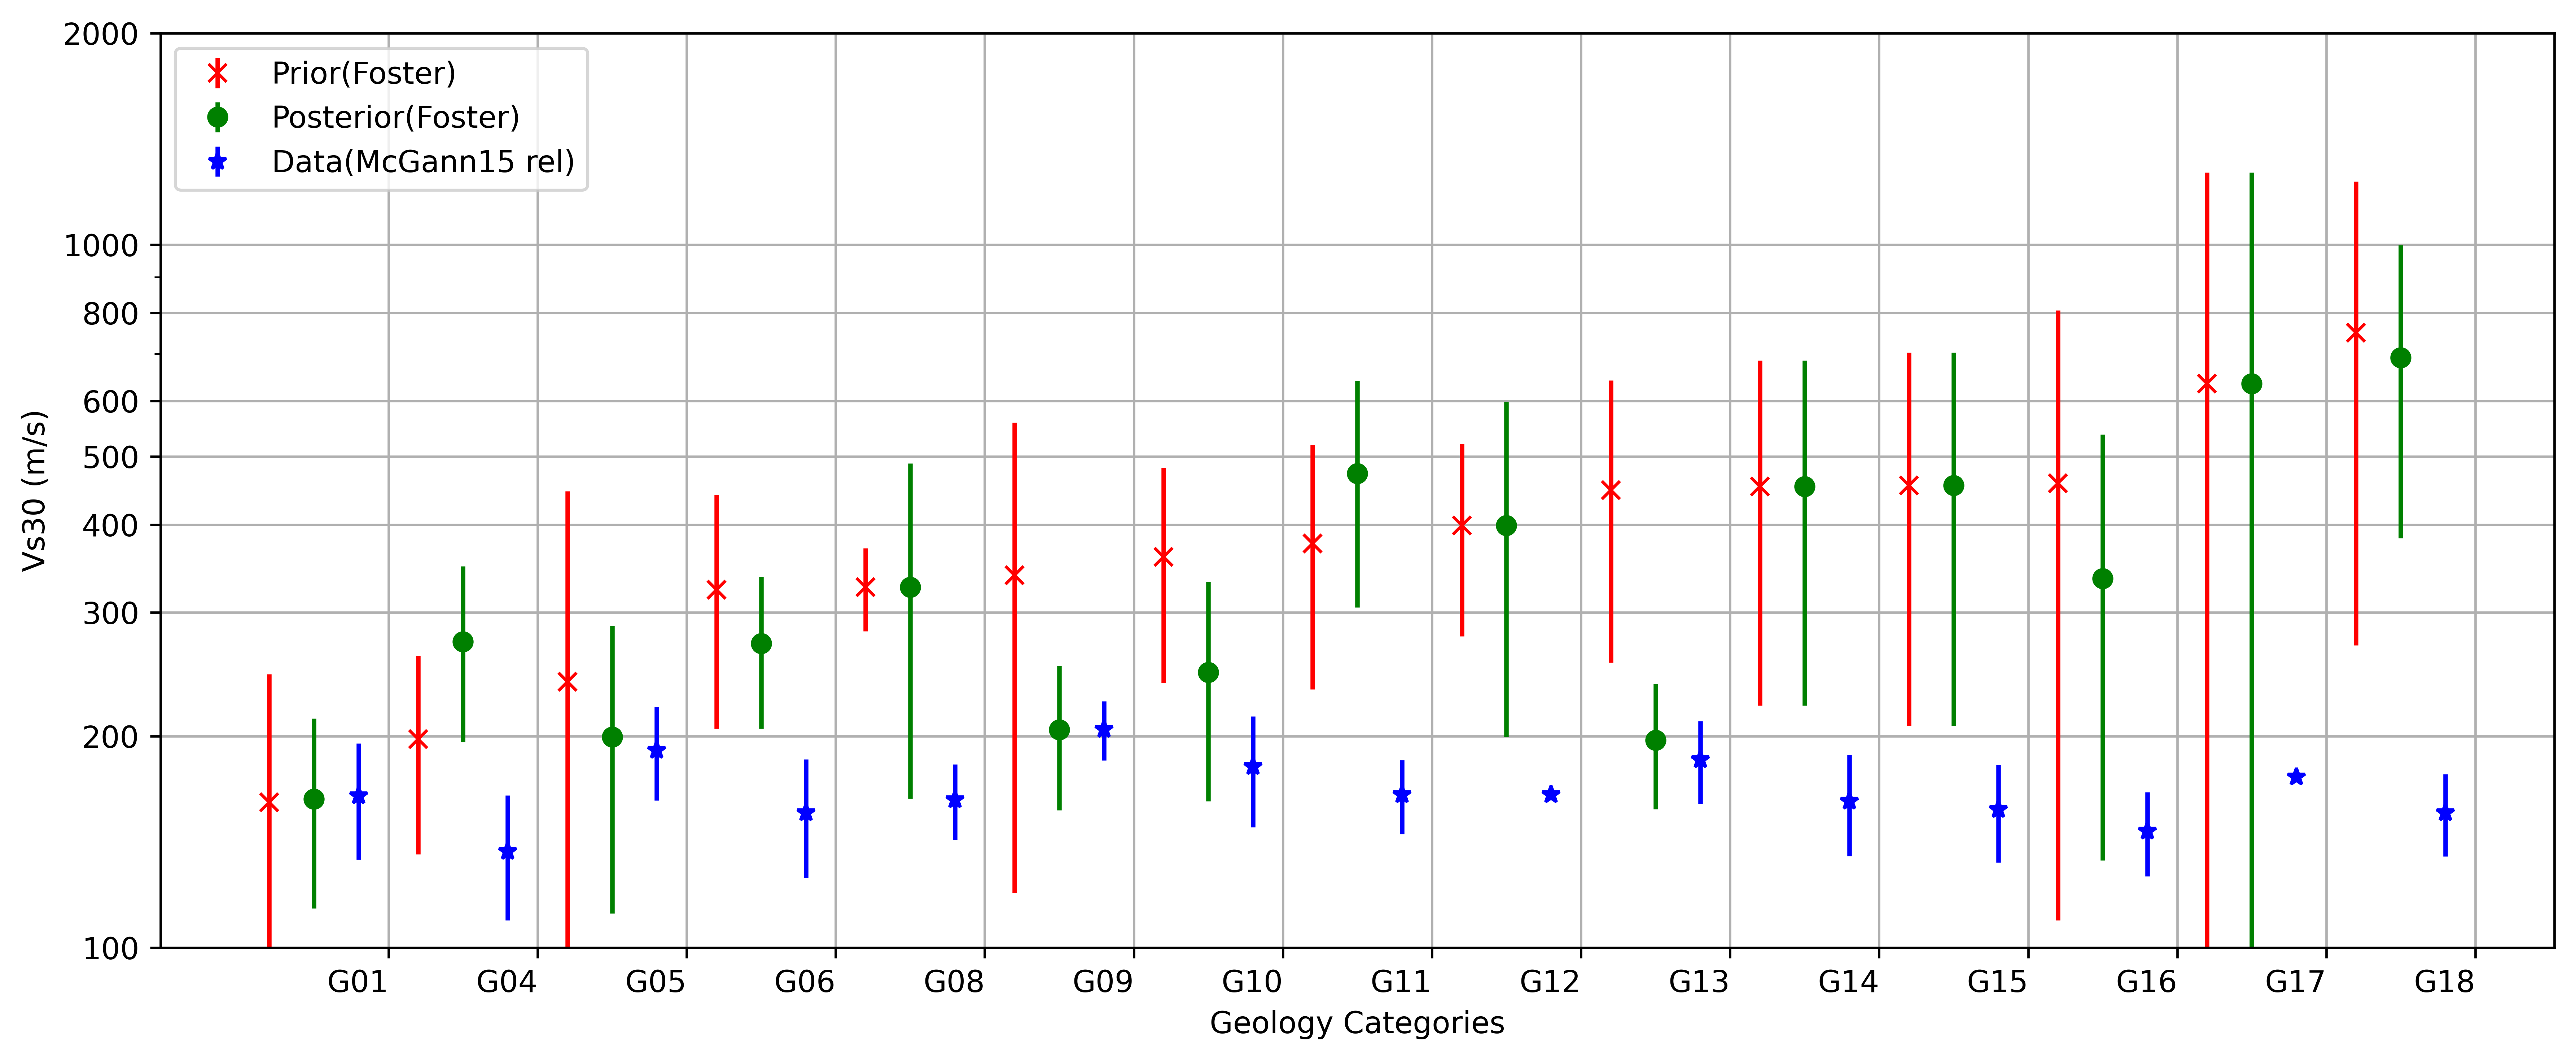

In [15]:
plt.rcParams['figure.dpi']=600
plt.rcParams["figure.figsize"] = (12,5)

data_dict = {
    "Prior(Foster)": [prior_means,prior_errors,'x','red'],
    "Posterior(Foster)": [posterior_means,posterior_errors,'o','green'],
    "Data(McGann15 rel)": [means,errors,"*","blue"]
}
plot_vs30_for_all_geo_ids(data_dict)

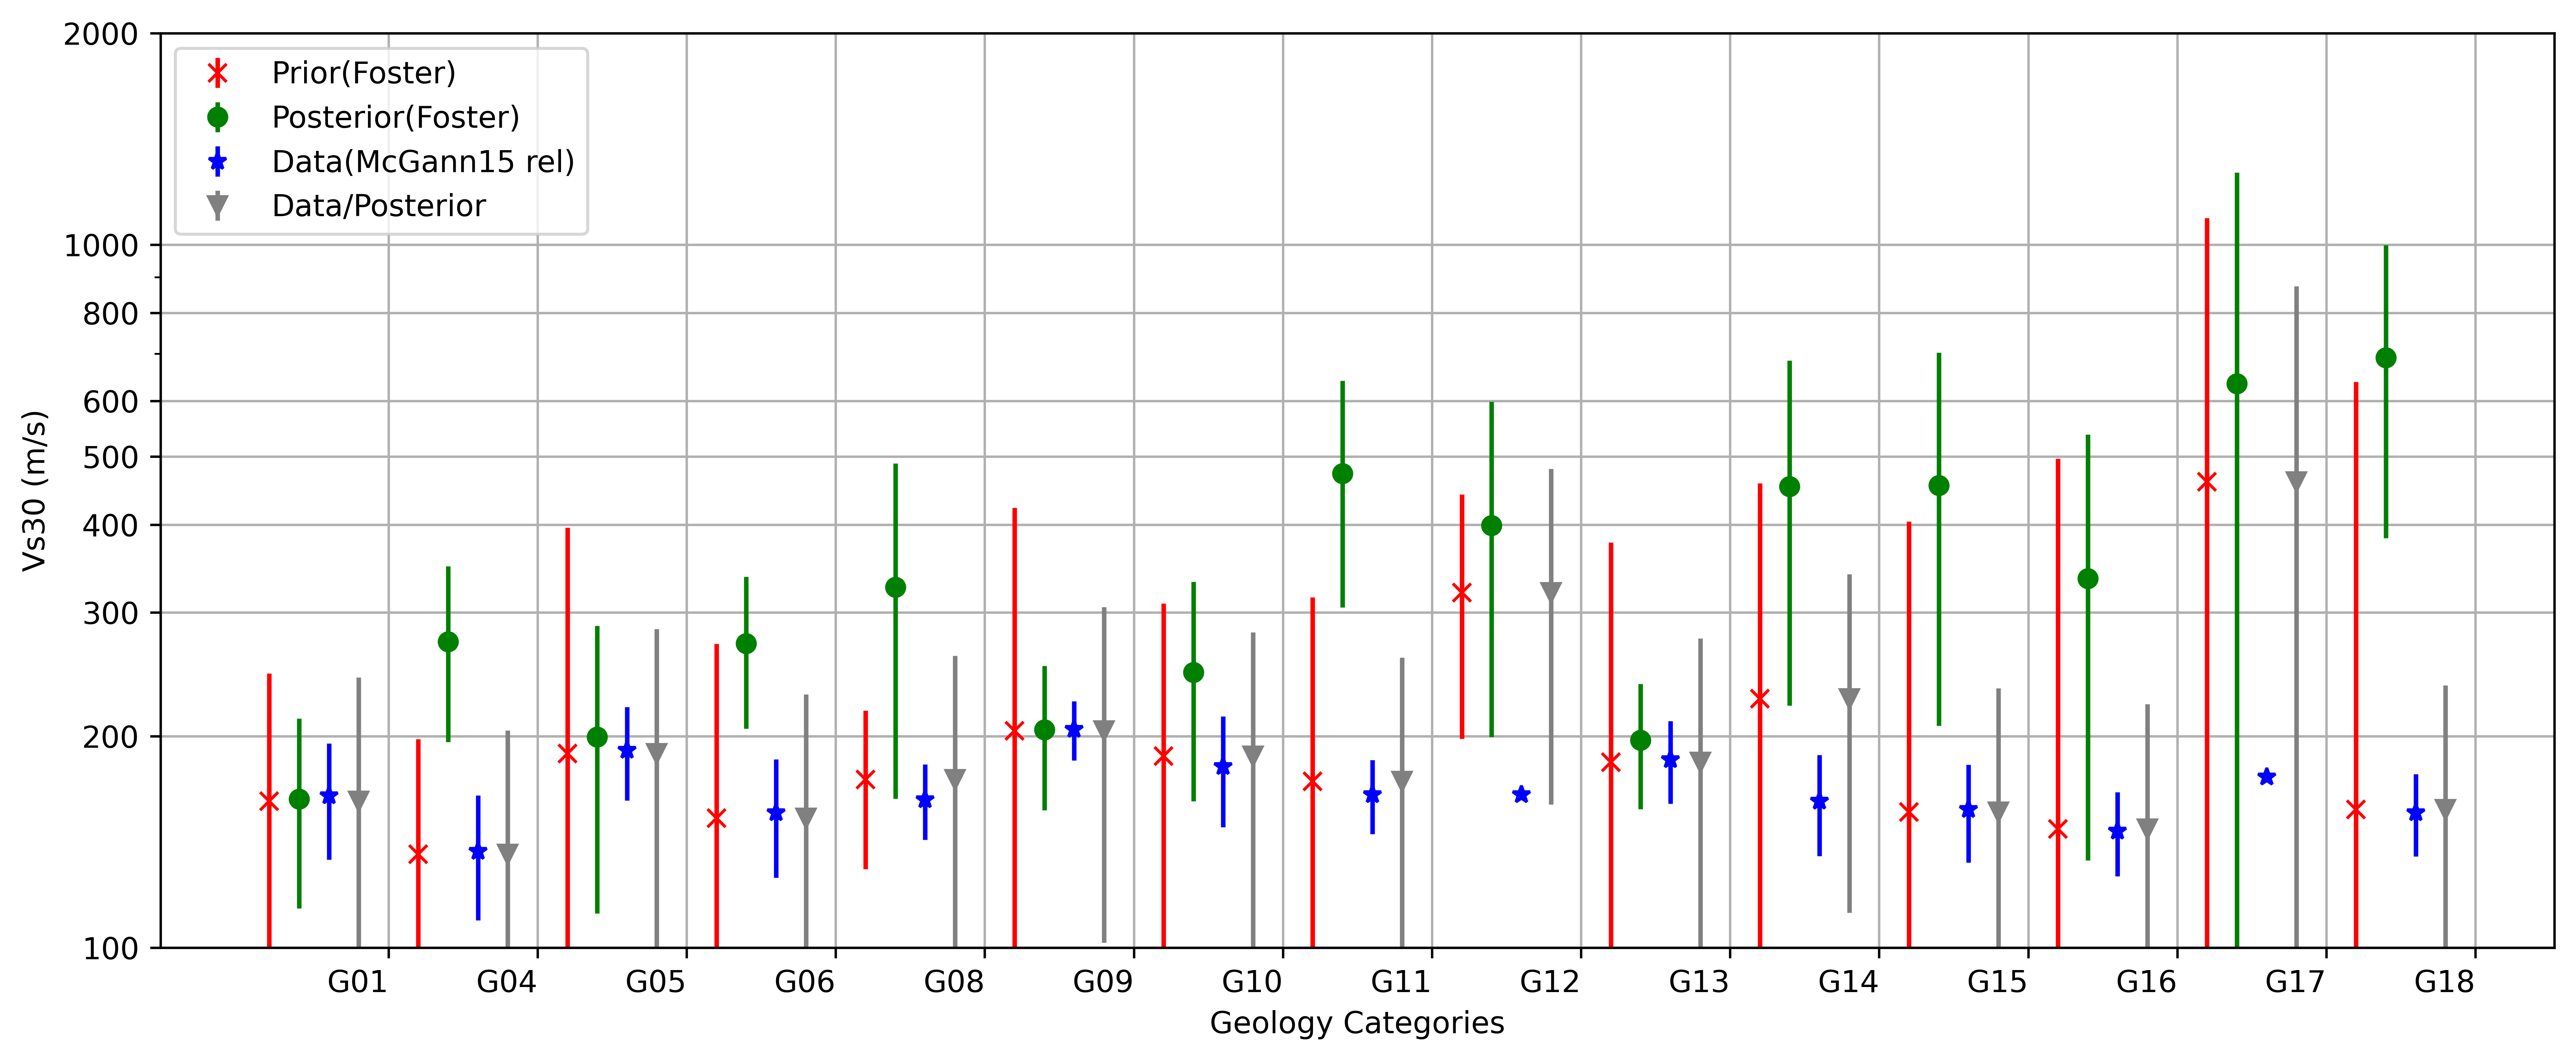

In [16]:


vs30_from_CPT=vs30_geo_id_df[['NZTM_X','NZTM_Y','Vs30','geo_model_idx']]
sites=vs30_from_CPT.loc[~np.isnan(np.float64(vs30_from_CPT['Vs30']))]
sites=sites.rename(columns={"NZTM_X":"easting","NZTM_Y":"northing","Vs30":"vs30"})
sites['gid']=np.array([x-1 for x in sites['geo_model_idx']]) #geo id is 1 greater than index in prior
sites['uncertainty']=0.5
sites
new_posterior=model.posterior(prior,sites,"gid")
new_posterior_means=new_posterior.T[0]
new_posterior_errors=new_posterior.T[1]*new_posterior_means

data_dict = {
    "Prior(Foster)": [prior_means,prior_errors,'x','red'],
    "Posterior(Foster)": [posterior_means,posterior_errors,'o','green'],
    "Data(McGann15 rel)": [means,errors,"*","blue"],
    "Data/Posterior": [new_posterior_means,new_posterior_errors,"v","grey"],
    
}
plot_vs30_for_all_geo_ids(data_dict)

In [17]:
plt.rcParams['figure.dpi']=600
plt.rcParams["figure.figsize"] = (6,3)



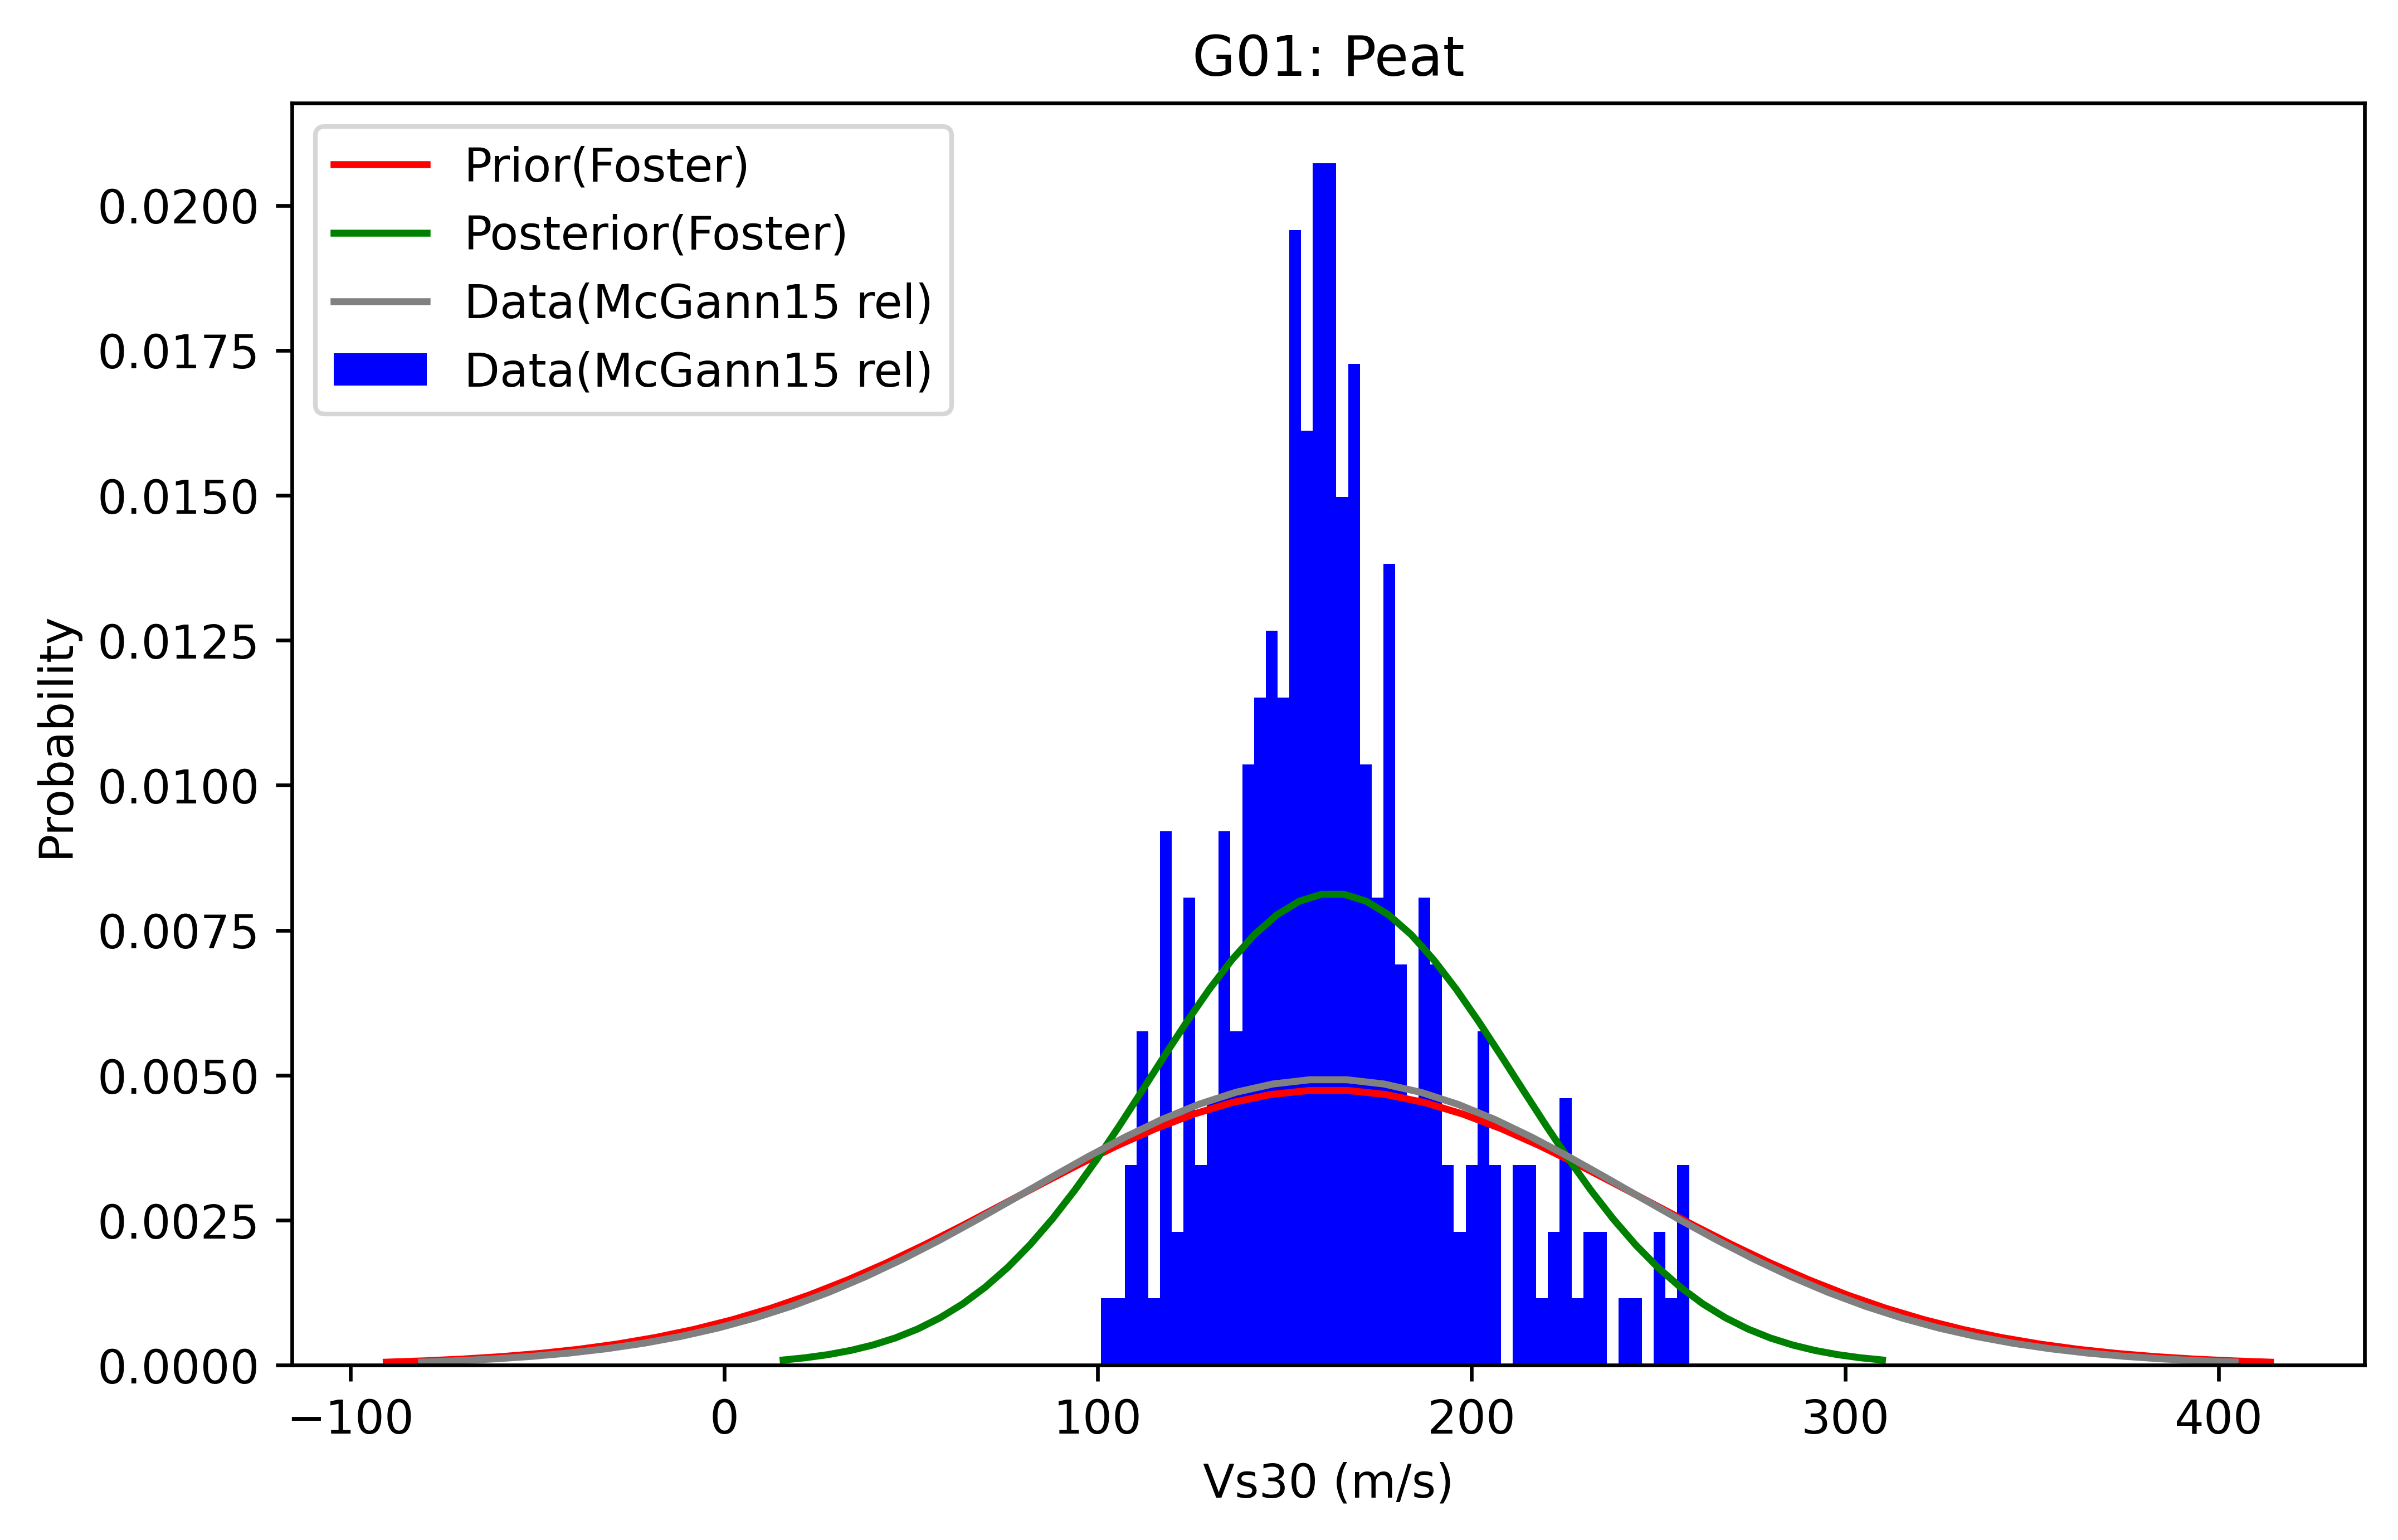

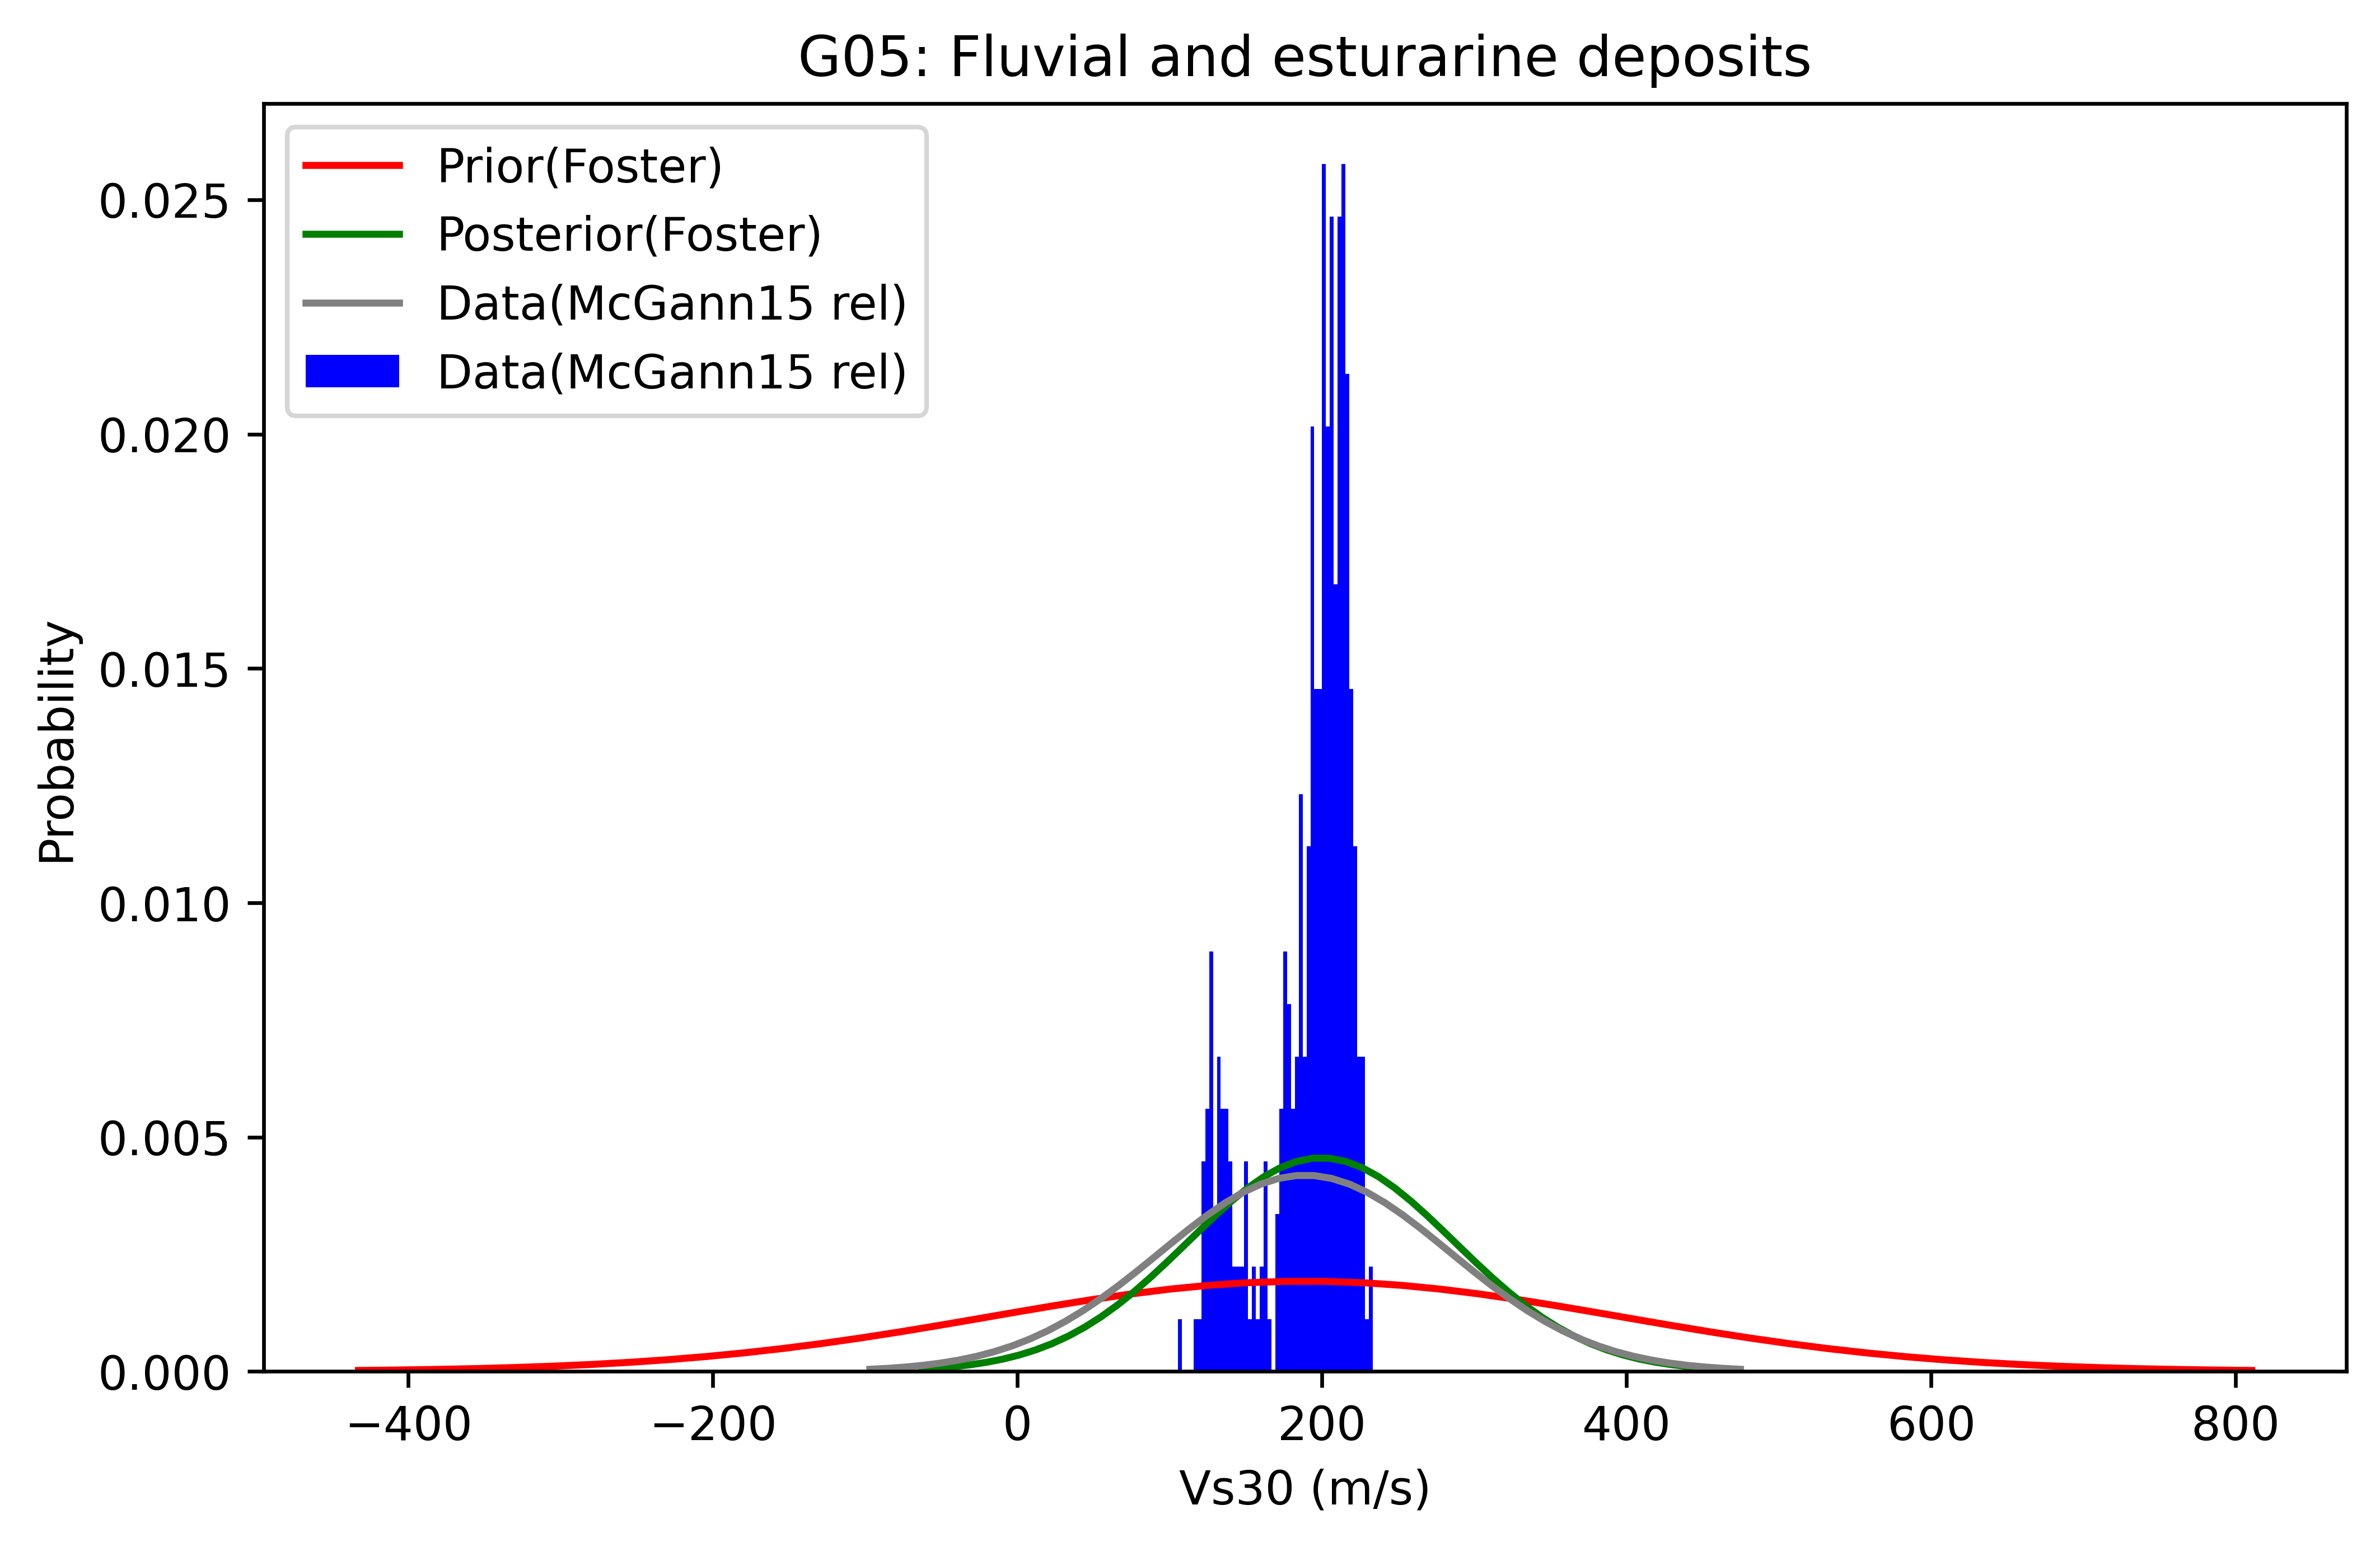

In [18]:

data_dict = {
        "Prior(Foster)": [prior_means,prior_errors,'red'],
        "Posterior(Foster)": [posterior_means,posterior_errors,'green'],
        "Data(McGann15 rel)": [new_posterior_means,new_posterior_errors,"gray"]
}

for i in range(1,4):
    plot_hist_dist(data_dict,i)

        

# Clustering

In [19]:
import sklearn
sklearn
sklearn.__version__
import importlib
from vs30 import sites_cluster
importlib.reload(sites_cluster)

<module 'vs30.sites_cluster' from '/data/sharing/QuakeCoRE/Vs30/vs30/sites_cluster.py'>

In [20]:
clustered_sites=sites_cluster.cluster(sites,min_group=100, eps=80000,letter="g")
features = np.column_stack((sites.easting.values, sites.northing.values))
print(clustered_sites.describe())


#for i in range(-1,cluster_num):
#    print("i:{} {}".format(i,len(cluster_sites.loc[cluster_sites.gcluster==i])))
clustered_sites.to_csv(outdir/"clustered_sites.csv")


            easting      northing         vs30  geo_model_idx          gid  \
count  7.541000e+03  7.541000e+03  7541.000000    7541.000000  7541.000000   
mean   1.666923e+06  5.423171e+06   181.397541       7.462273     6.462273   
std    1.325265e+05  3.188840e+05    31.918742       3.401796     3.401796   
min    1.257994e+06  4.903444e+06    63.245399       1.000000     0.000000   
25%    1.574175e+06  5.181452e+06   158.187393       6.000000     5.000000   
50%    1.576615e+06  5.184344e+06   185.509596       6.000000     5.000000   
75%    1.769529e+06  5.815862e+06   207.708051      10.000000     9.000000   
max    2.063247e+06  6.143386e+06   282.383524      15.000000    14.000000   

       uncertainty     gcluster  
count       7541.0  7541.000000  
mean           0.5    -0.068426  
std            0.0     0.347918  
min            0.5    -1.000000  
25%            0.5     0.000000  
50%            0.5     0.000000  
75%            0.5     0.000000  
max            0.5     1.

Gid=0 # clusters=2
Gid=1 # clusters=1
Gid=2 # clusters=2
Gid=3 # clusters=2
Gid=4 # clusters=1
Gid=5 # clusters=3
Gid=6 # clusters=1
Gid=7 # clusters=1
Gid=8 # clusters=1
Gid=9 # clusters=1
Gid=10 # clusters=1
Gid=11 # clusters=2
Gid=12 # clusters=2
Gid=13 # clusters=1
Gid=14 # clusters=2


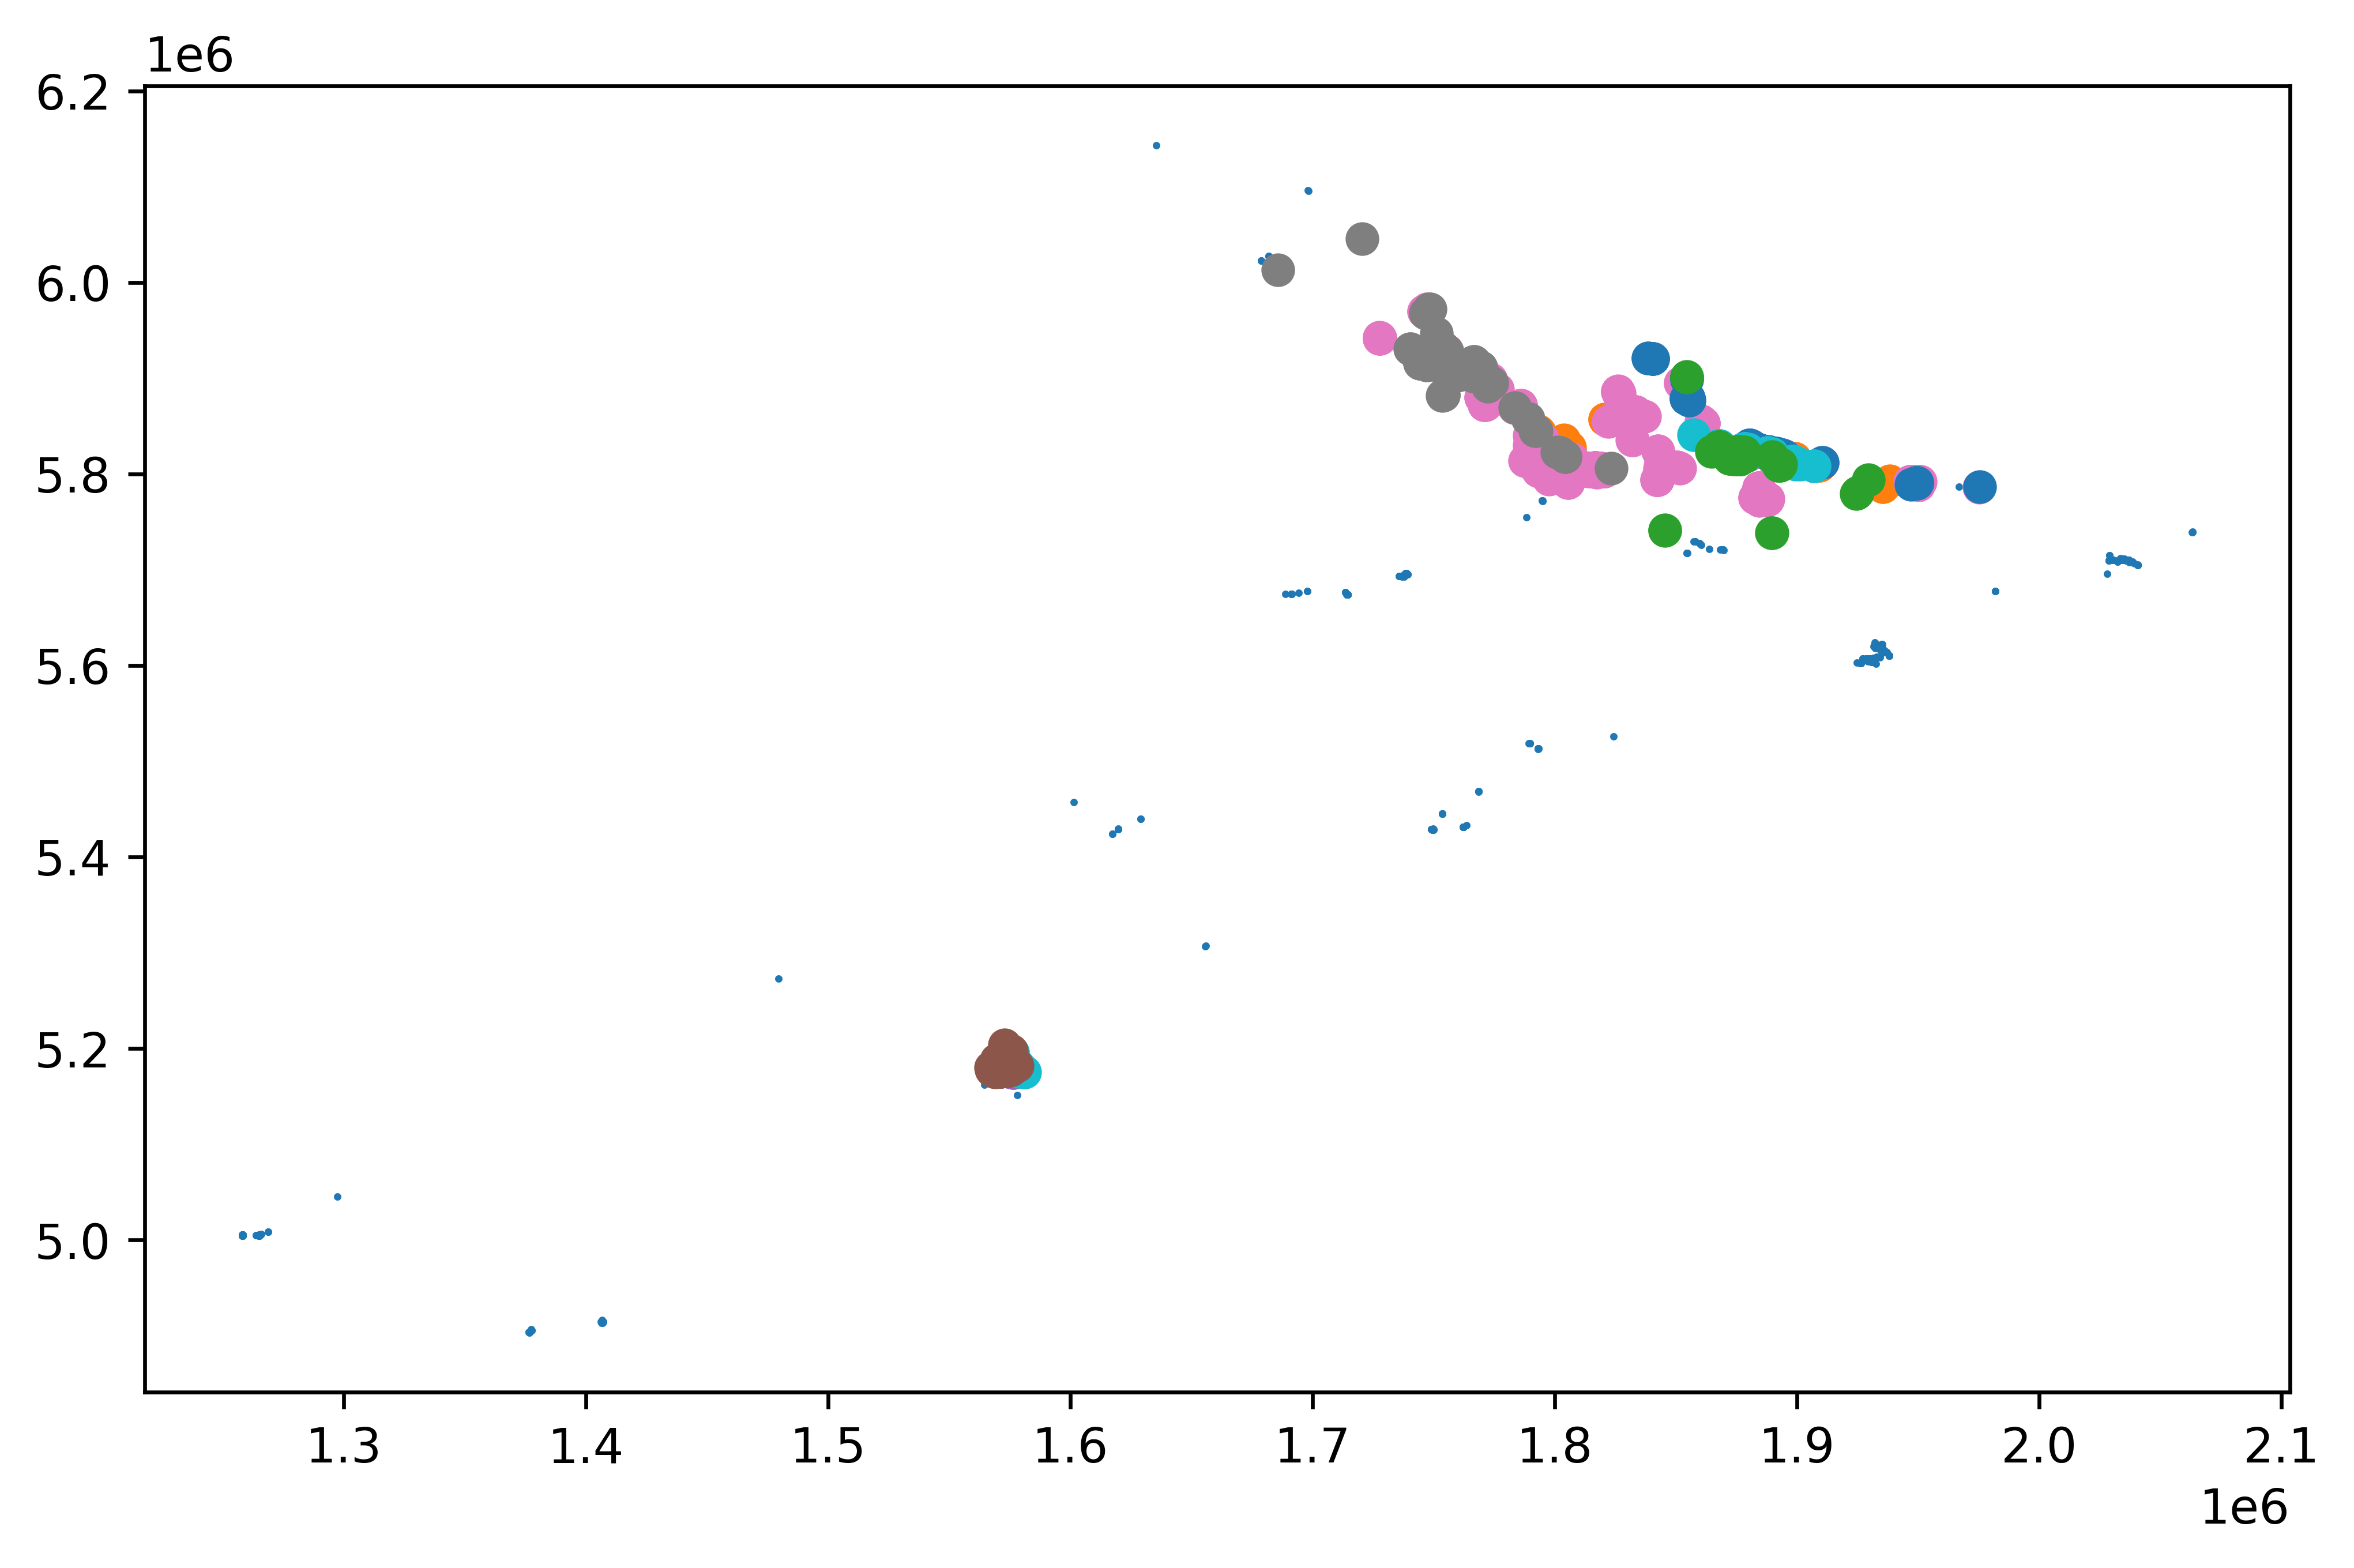

In [21]:
fig,ax=plt.subplots()

ax.scatter(features[:,0],features[:,1],s=0.3)
for g in range(0,15):
#for g in range(0,1):
    clustered_sites_gid = clustered_sites.loc[clustered_sites.gid==g]
    counts = clustered_sites_gid.nunique()
    print("Gid={} # clusters={}".format(g,counts.gcluster))
    for c in range(0,counts.gcluster):
    #for c in range(0,1):
        a_cluster=clustered_sites_gid.loc[clustered_sites_gid.gcluster==c]
        ax.scatter(a_cluster.easting,a_cluster.northing)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()


In [22]:
from vs30 import model
clustered_posterior=model.cluster_update(new_posterior,clustered_sites,"g")
clustered_posterior_means = clustered_posterior.T[0]
clustered_posterior_errors = clustered_posterior.T[1]*clustered_posterior_means

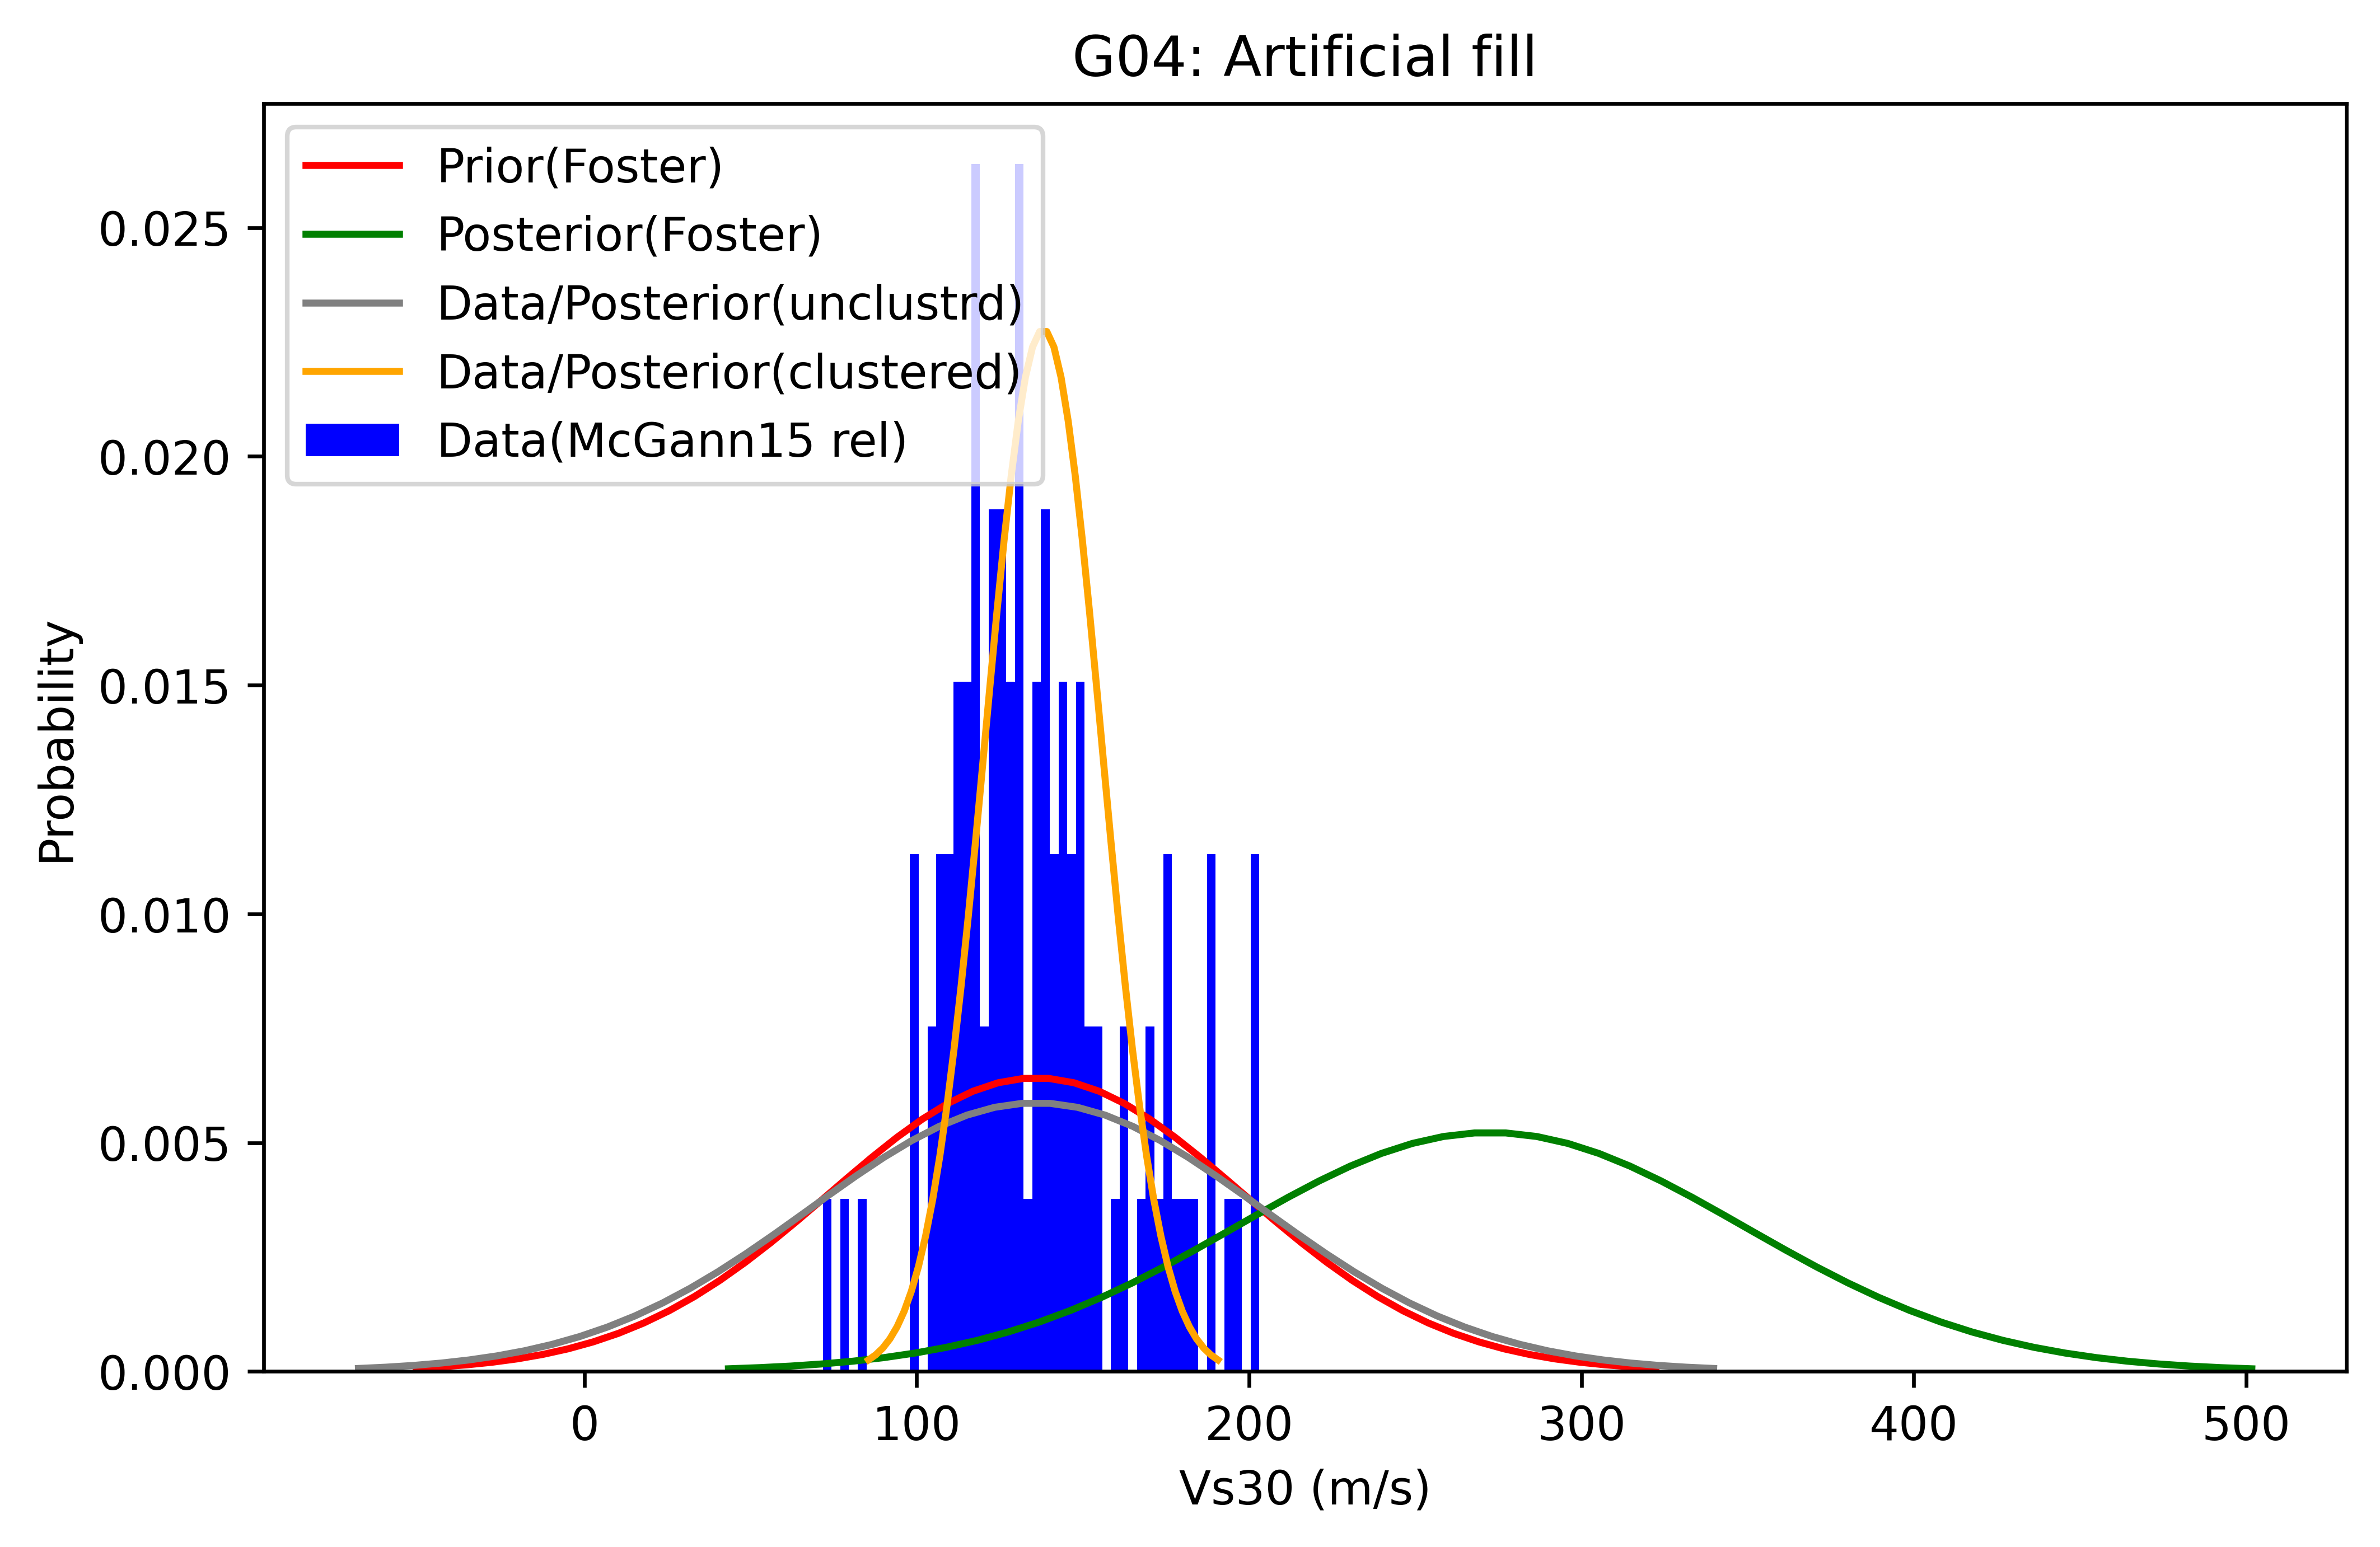

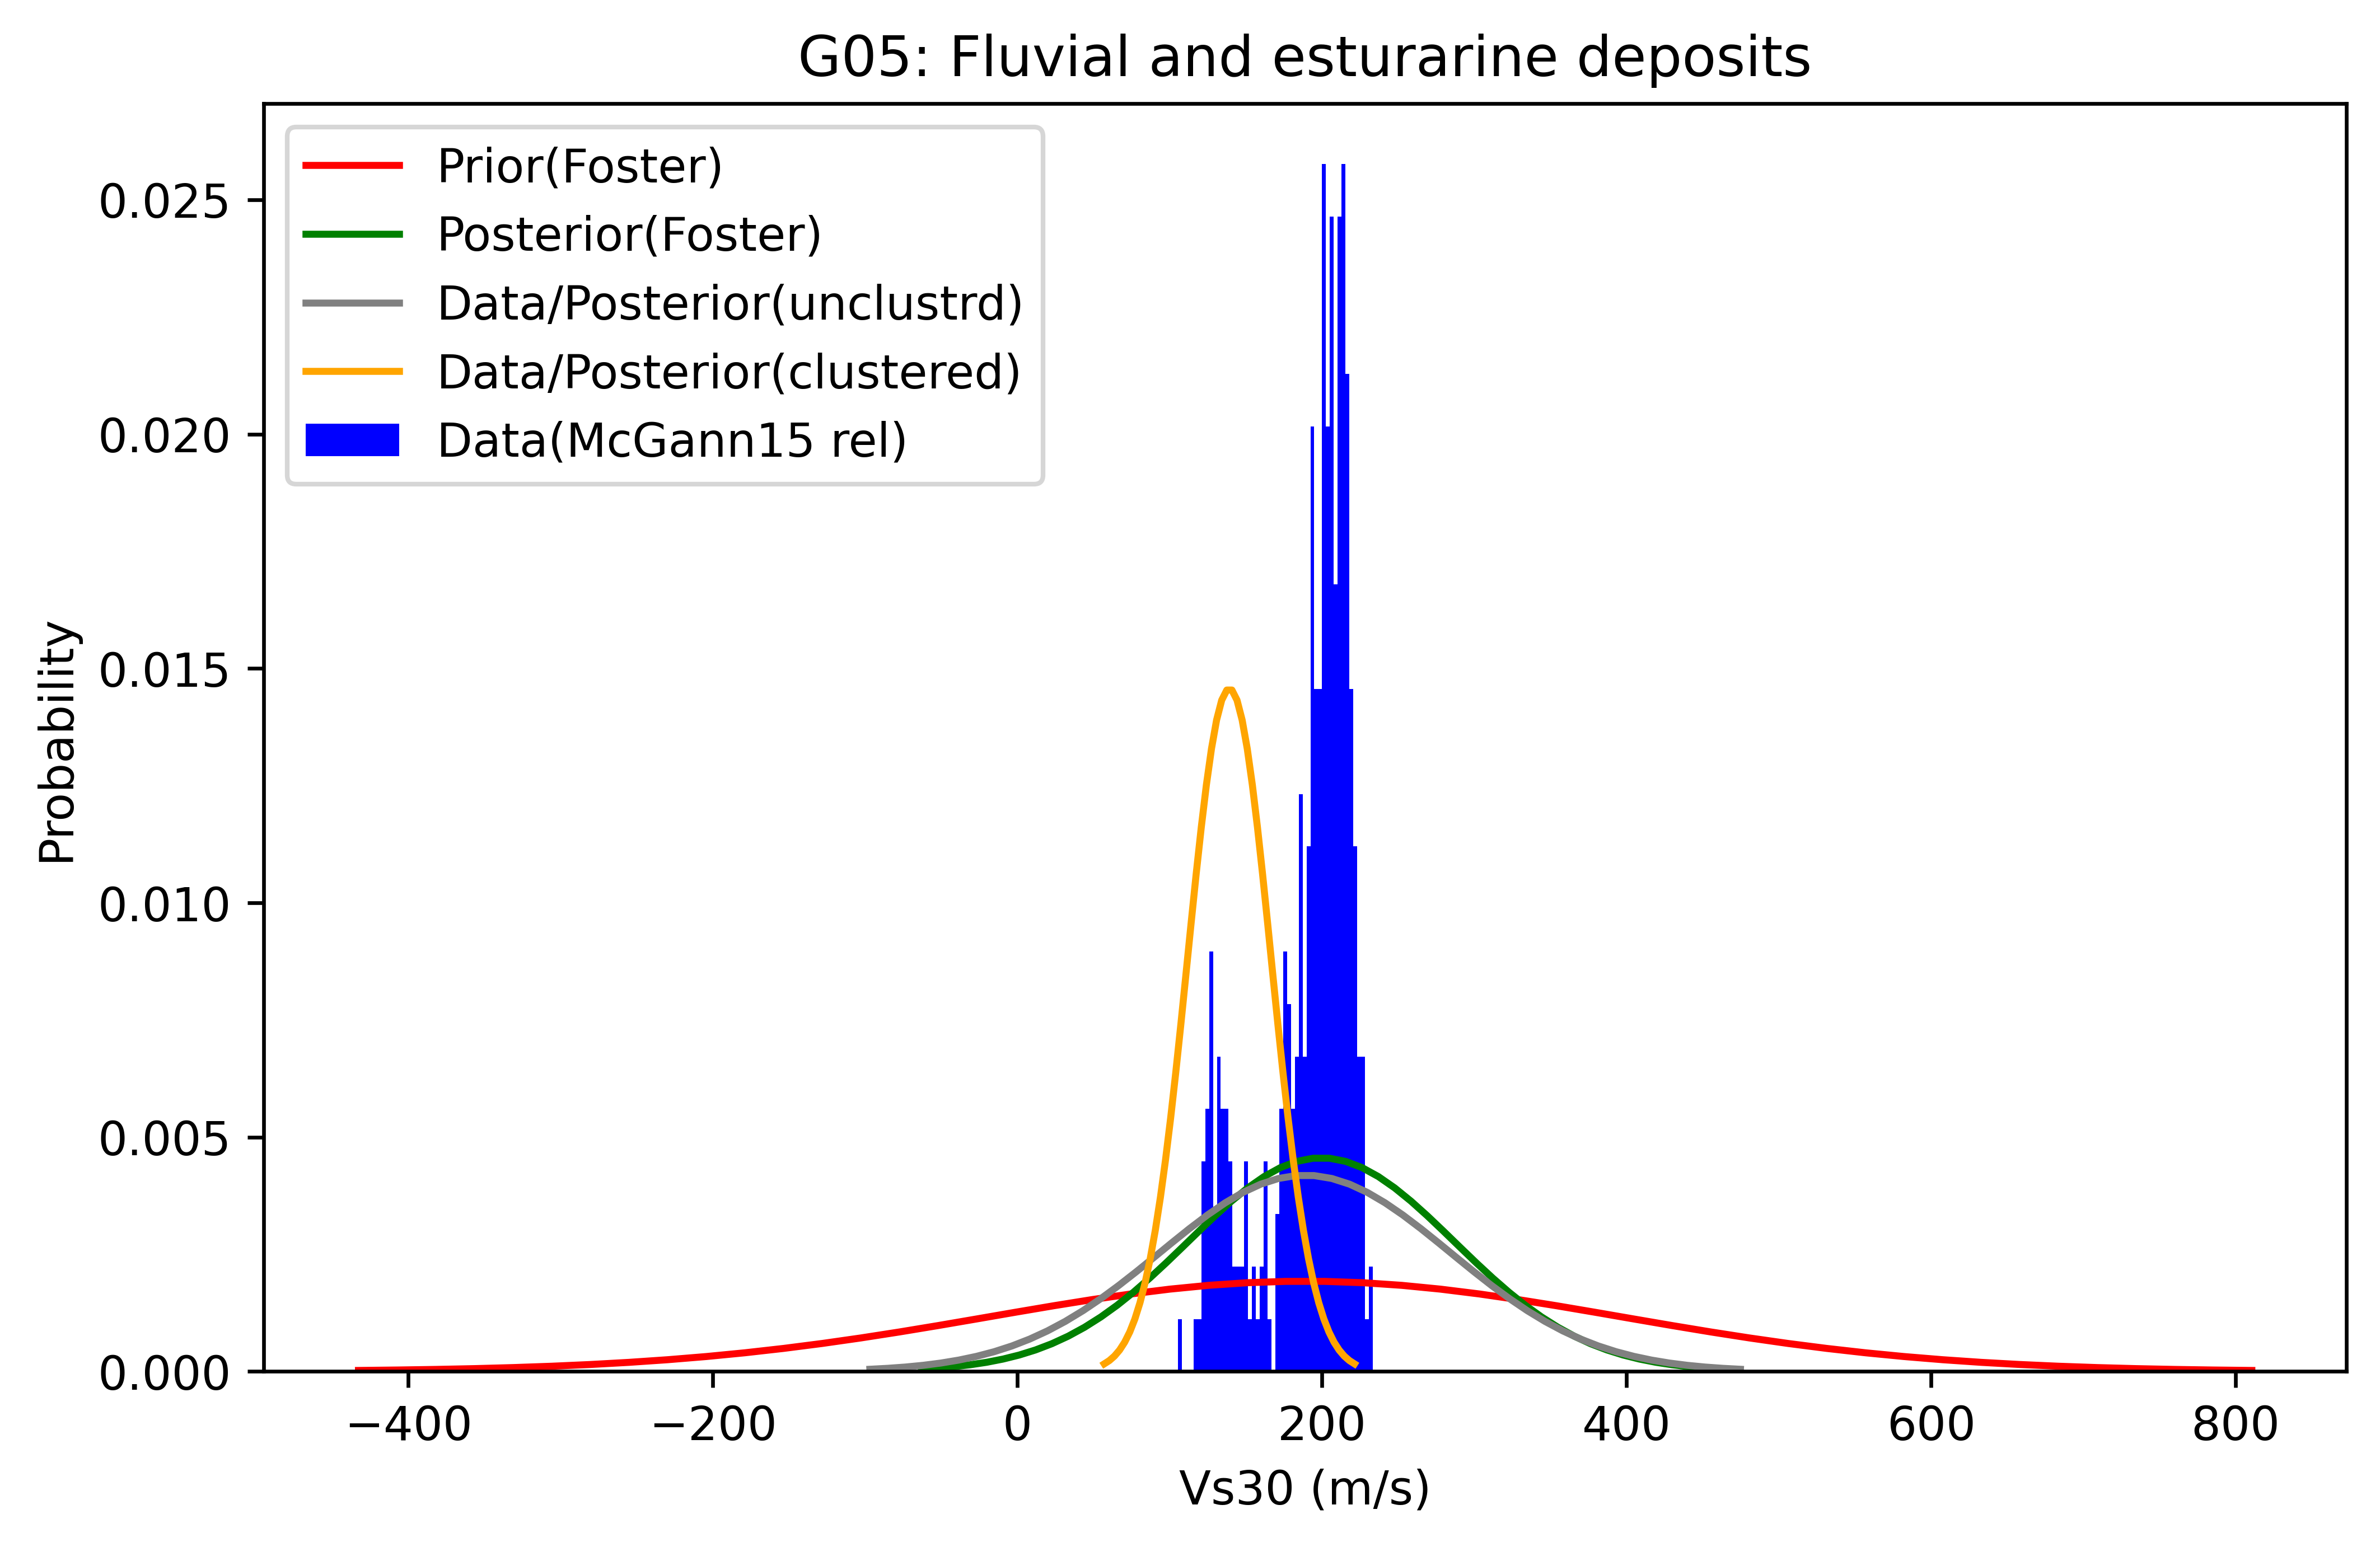

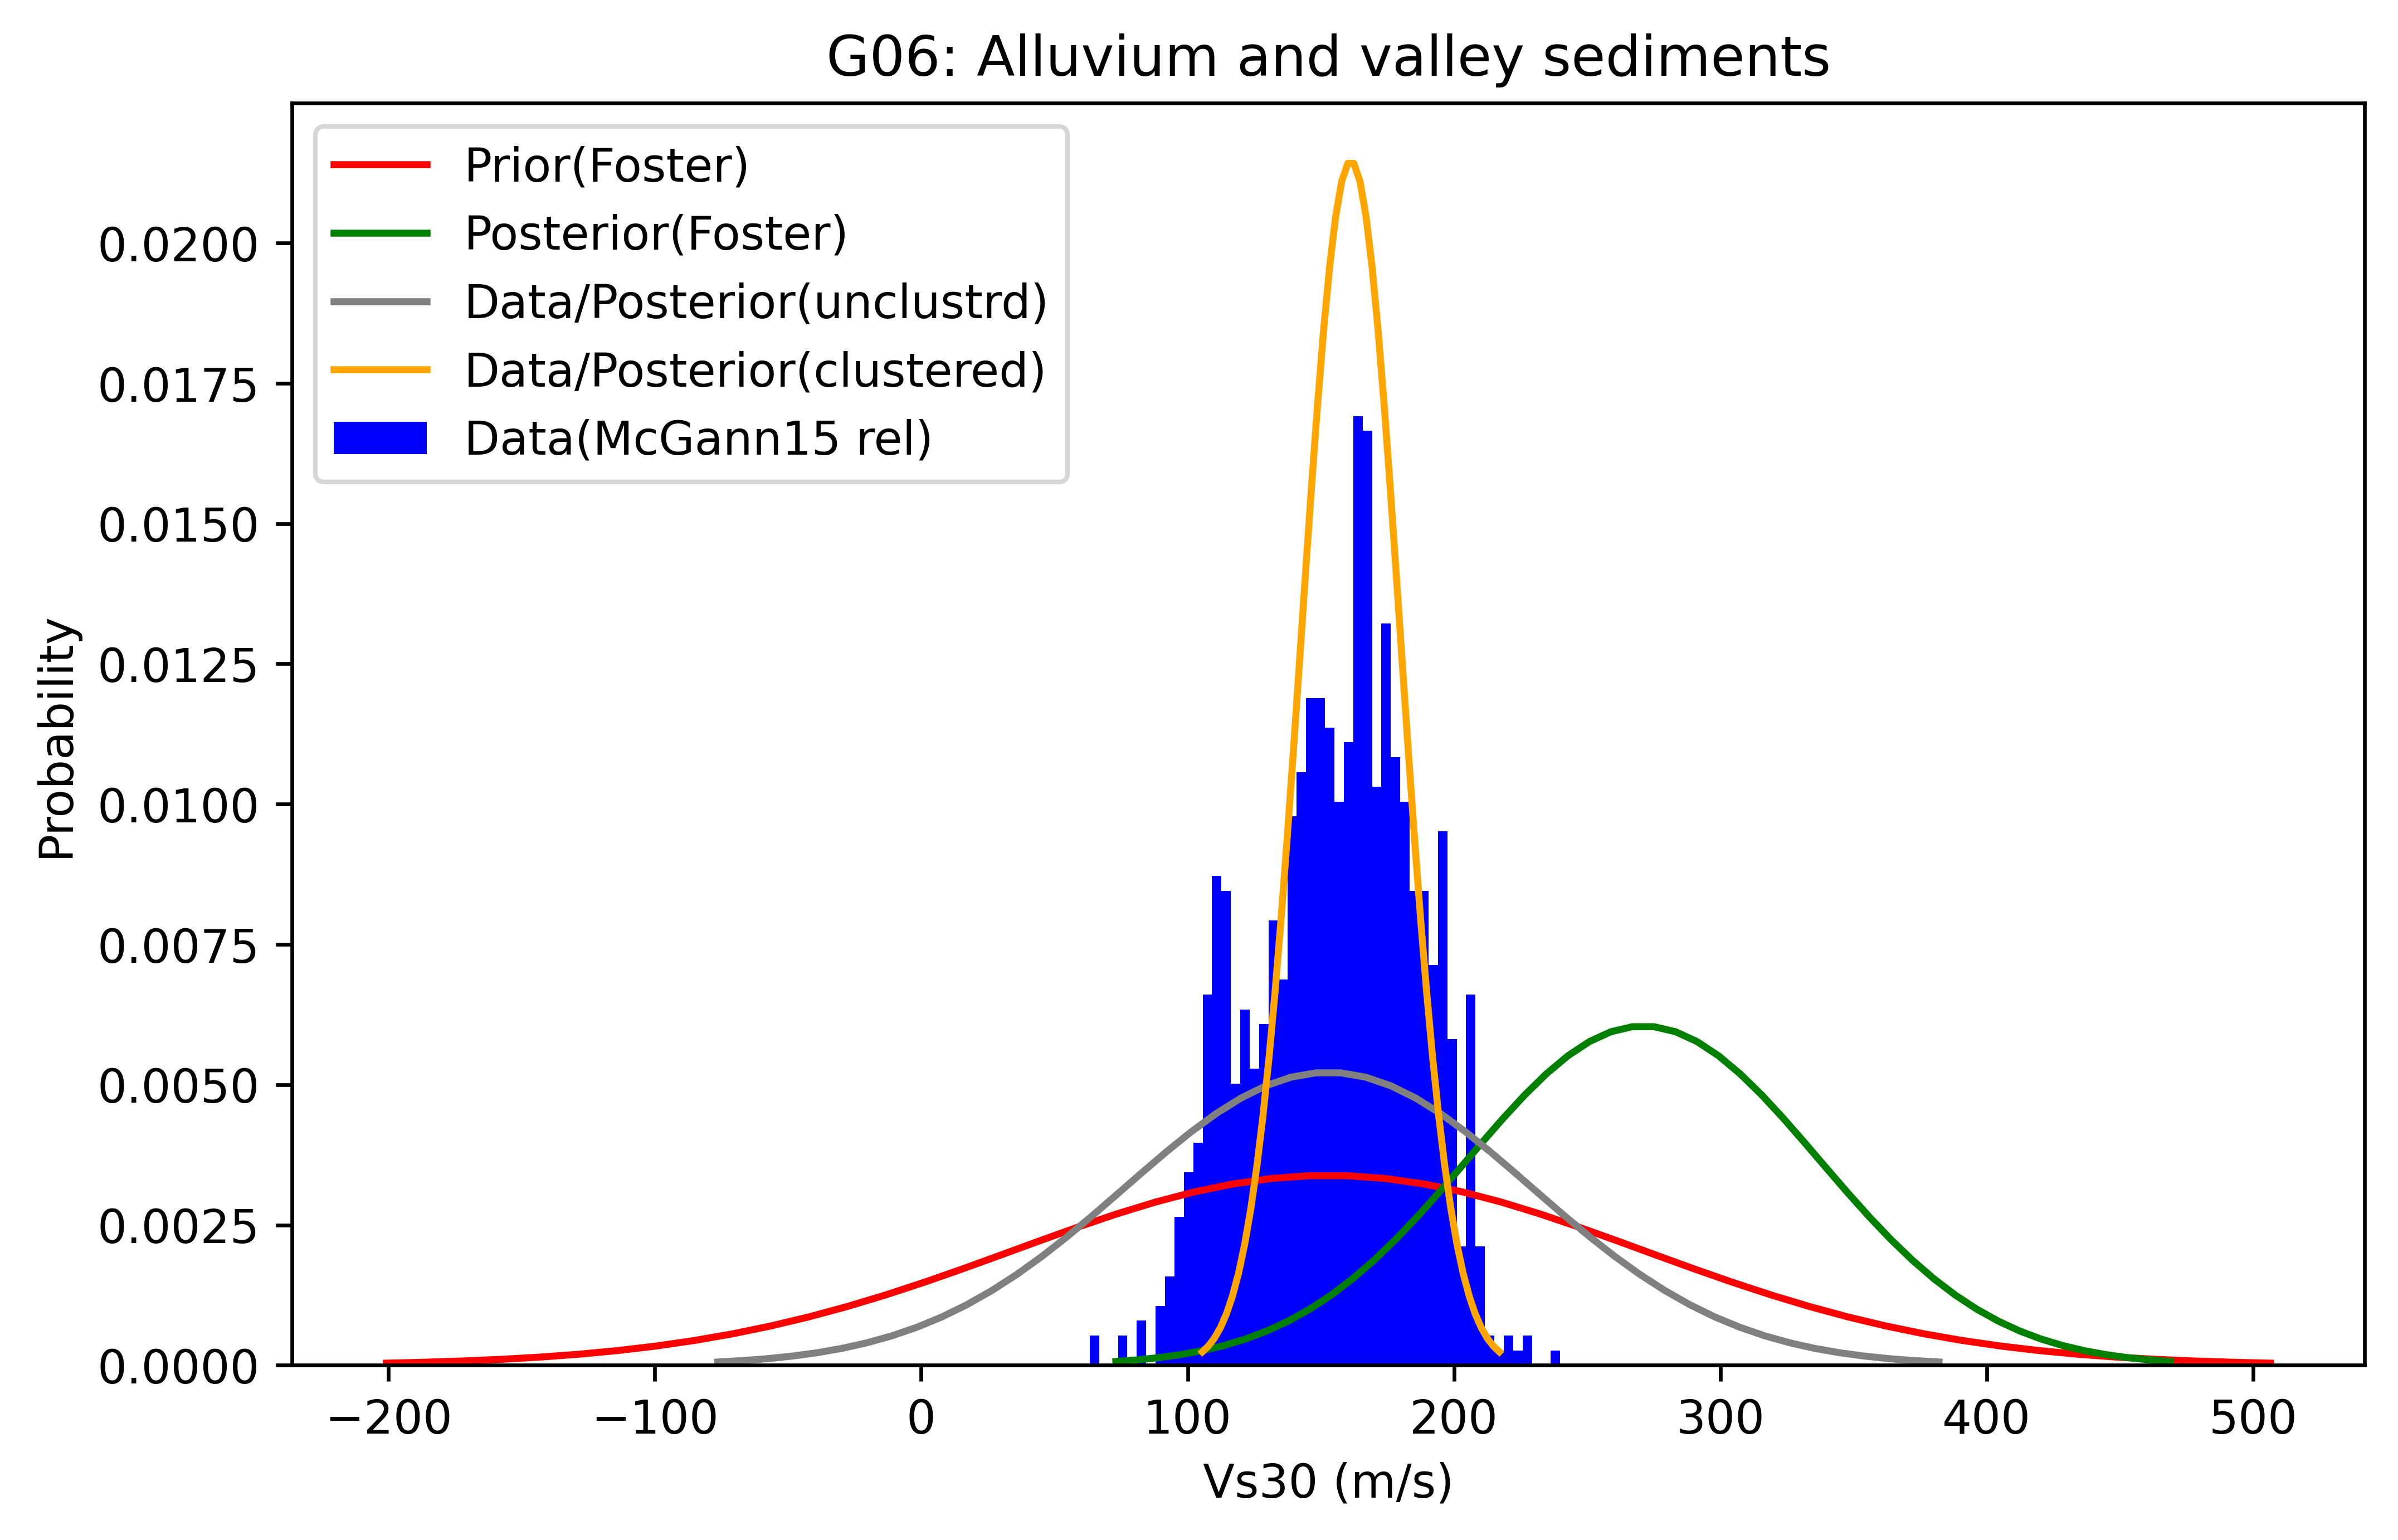

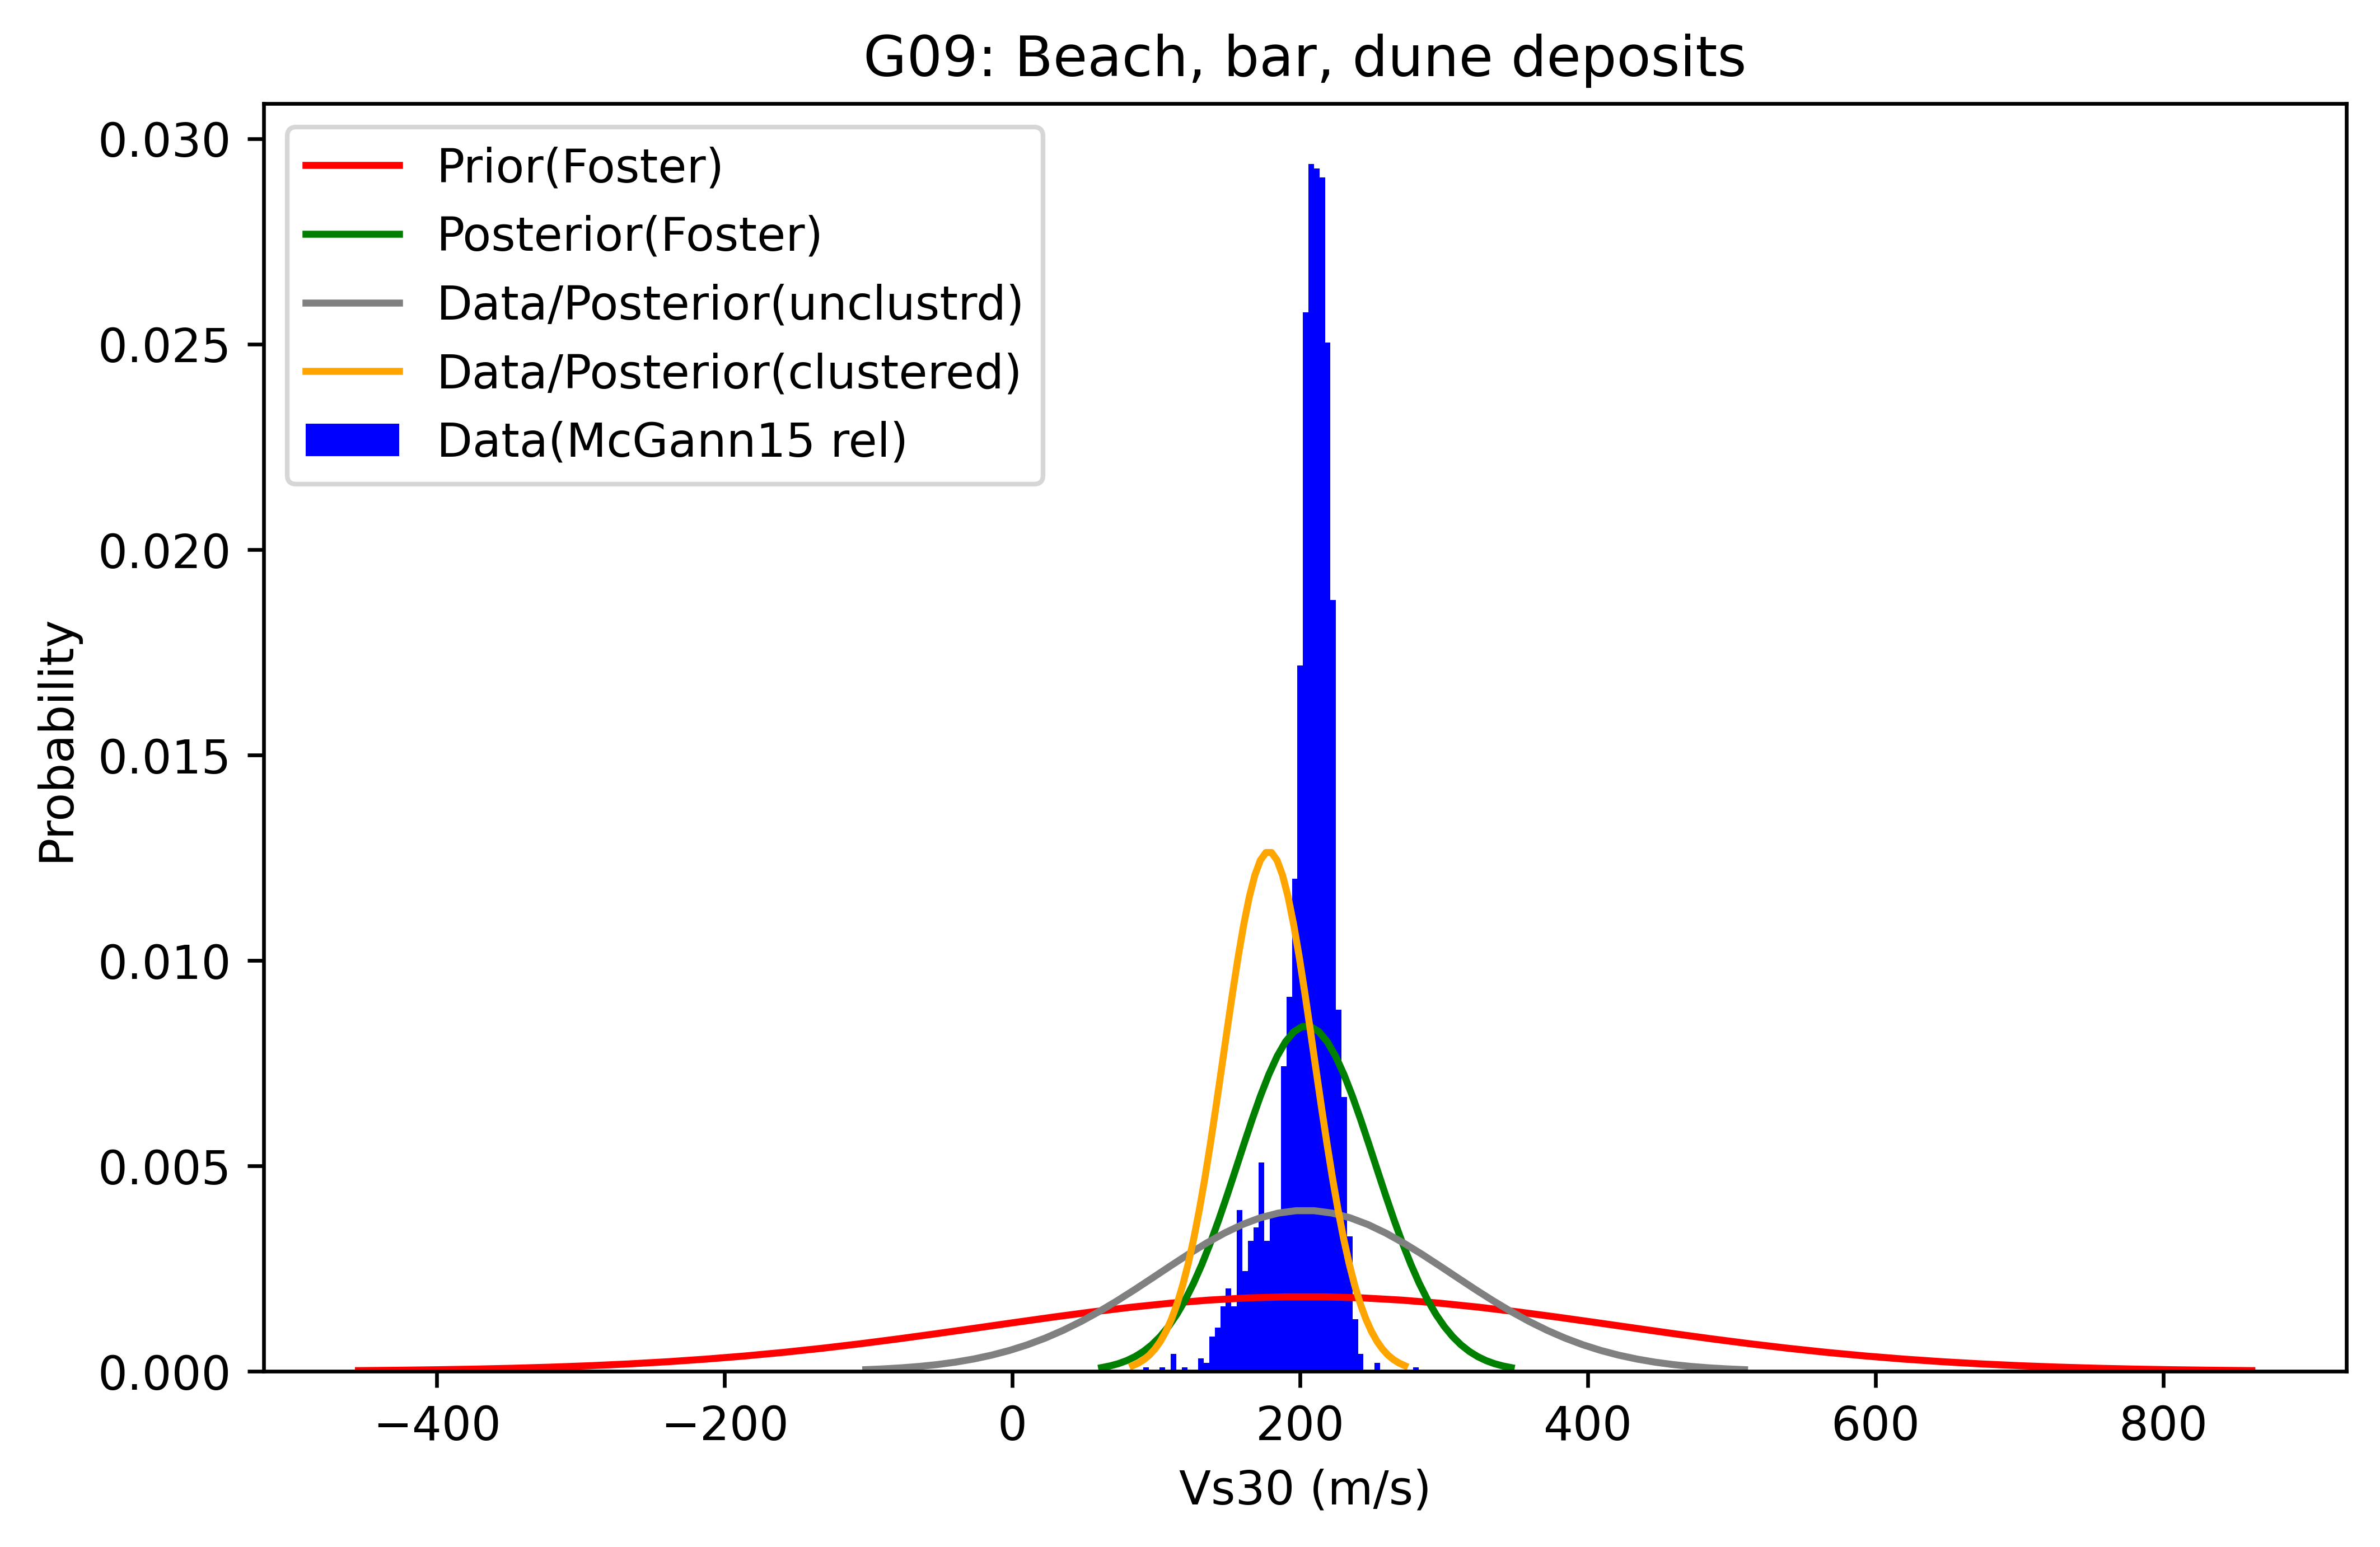

/opt/miniconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


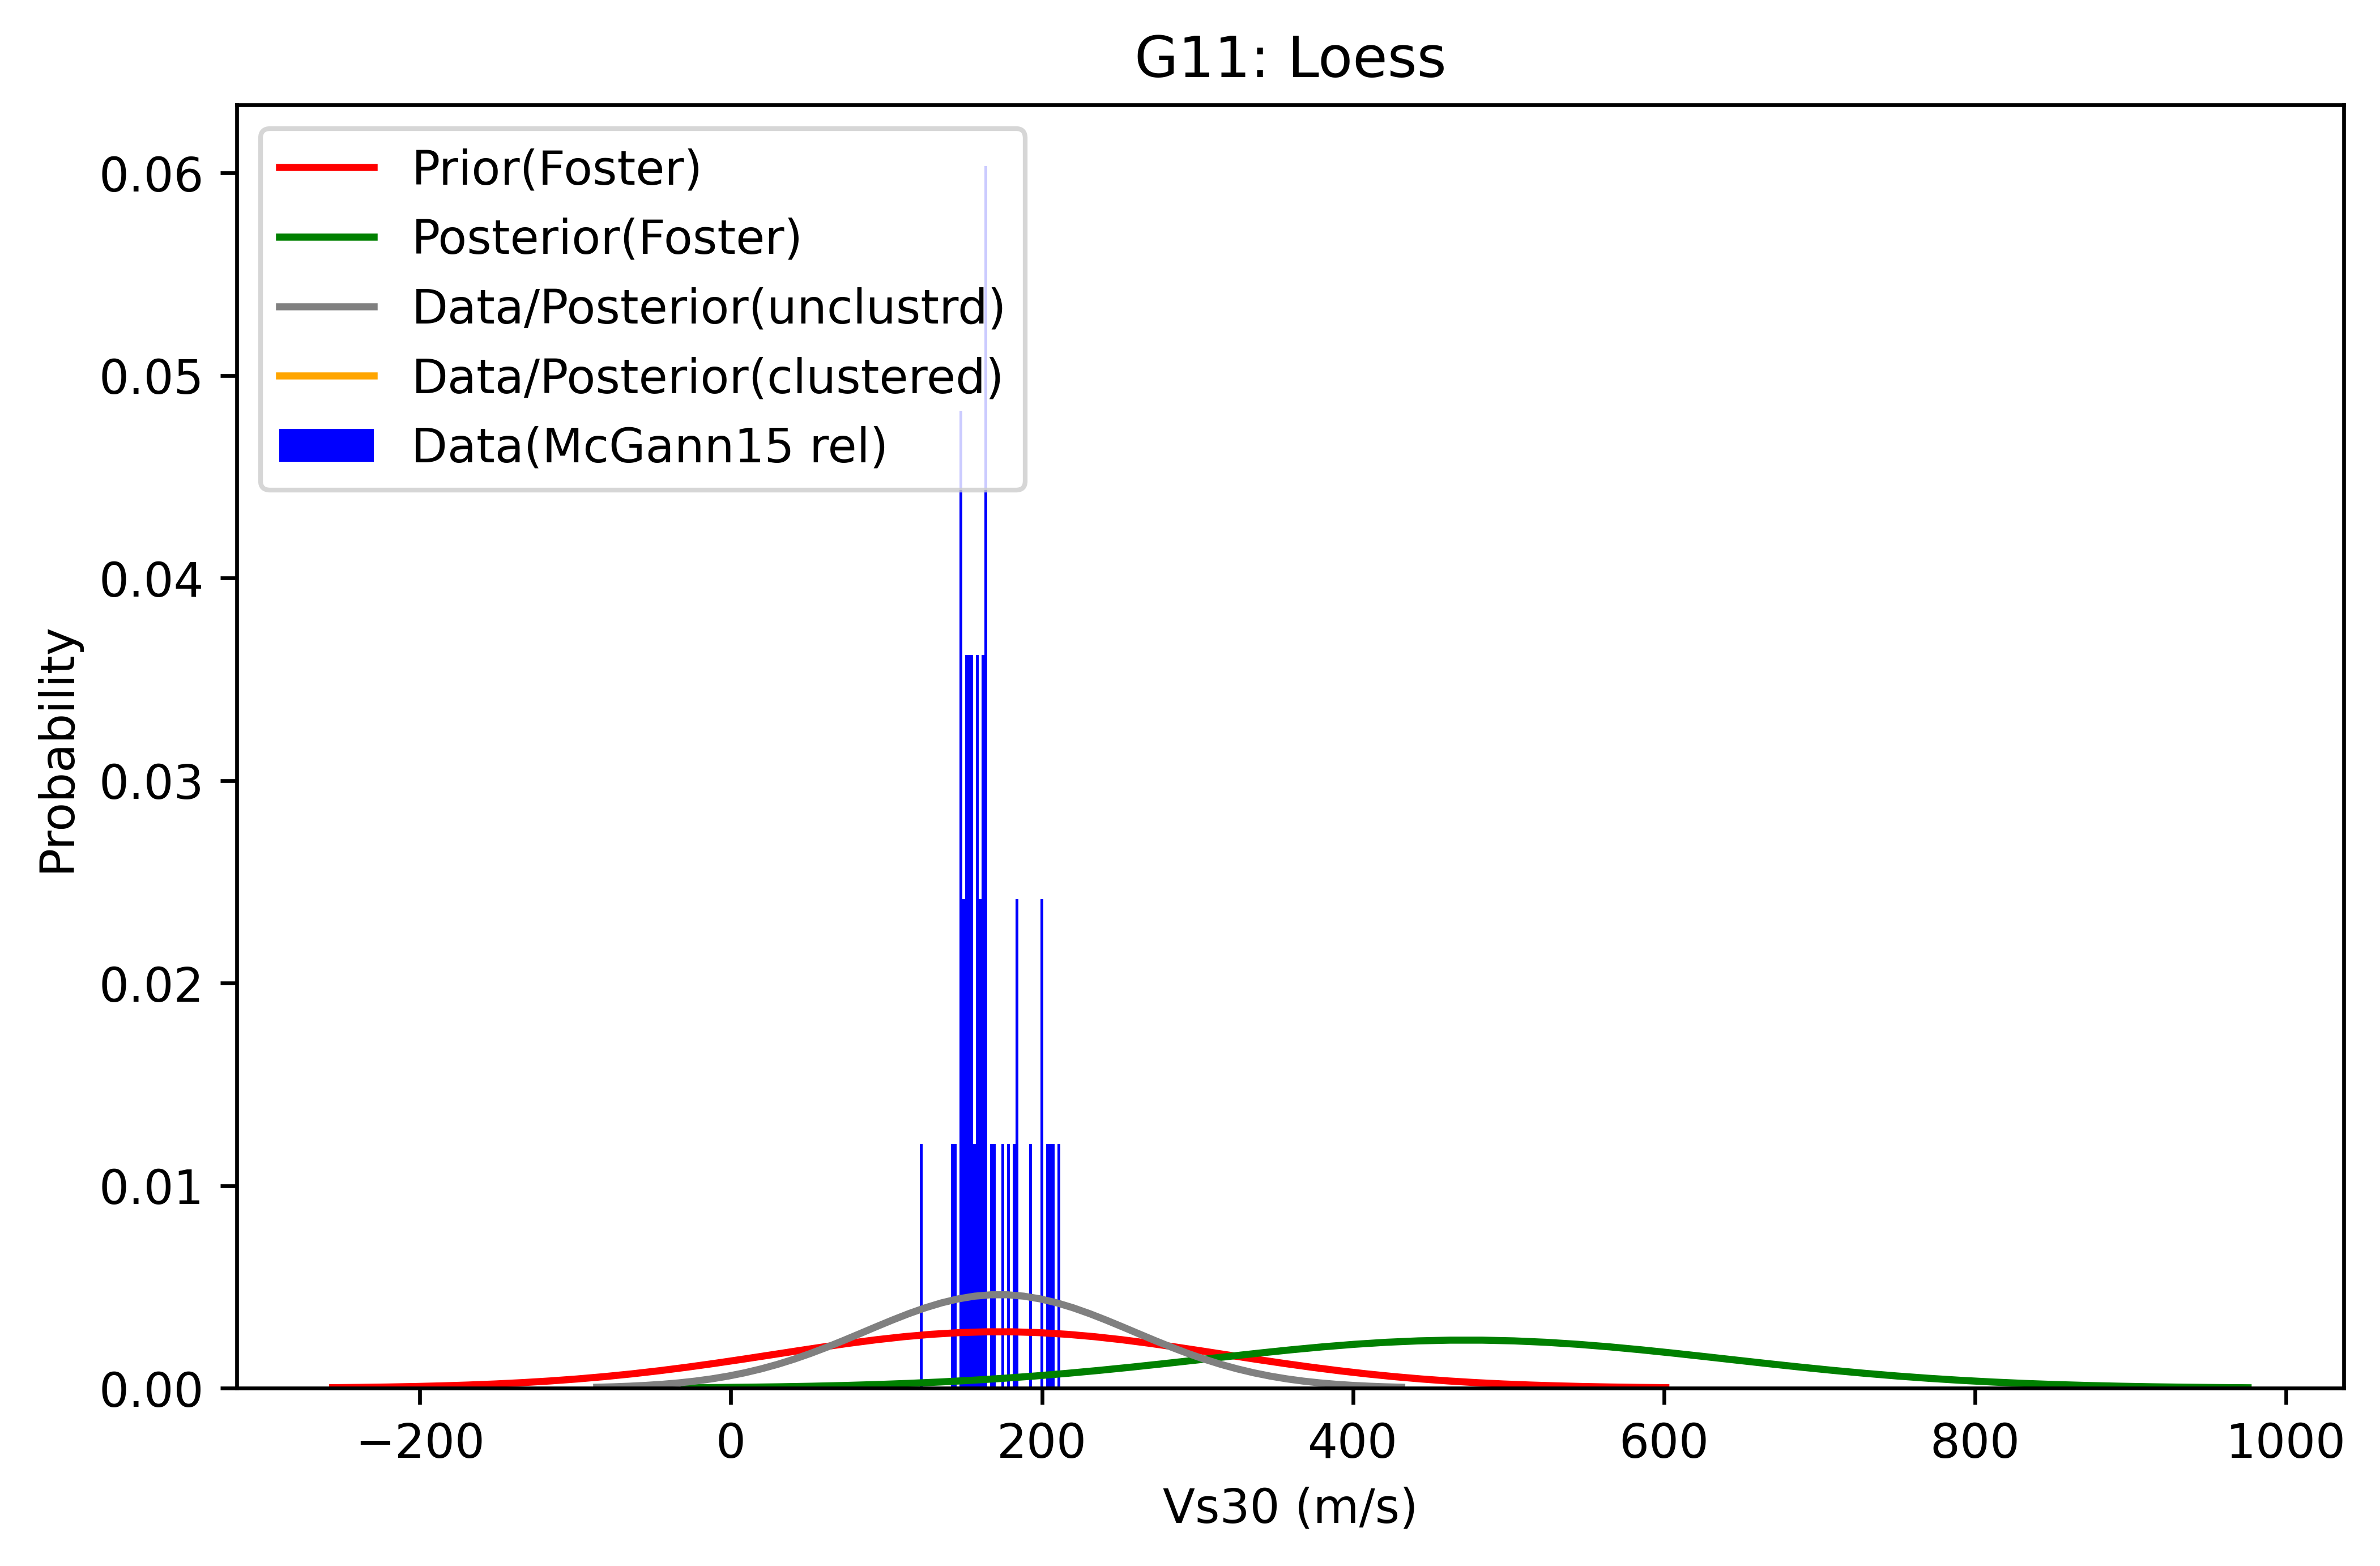

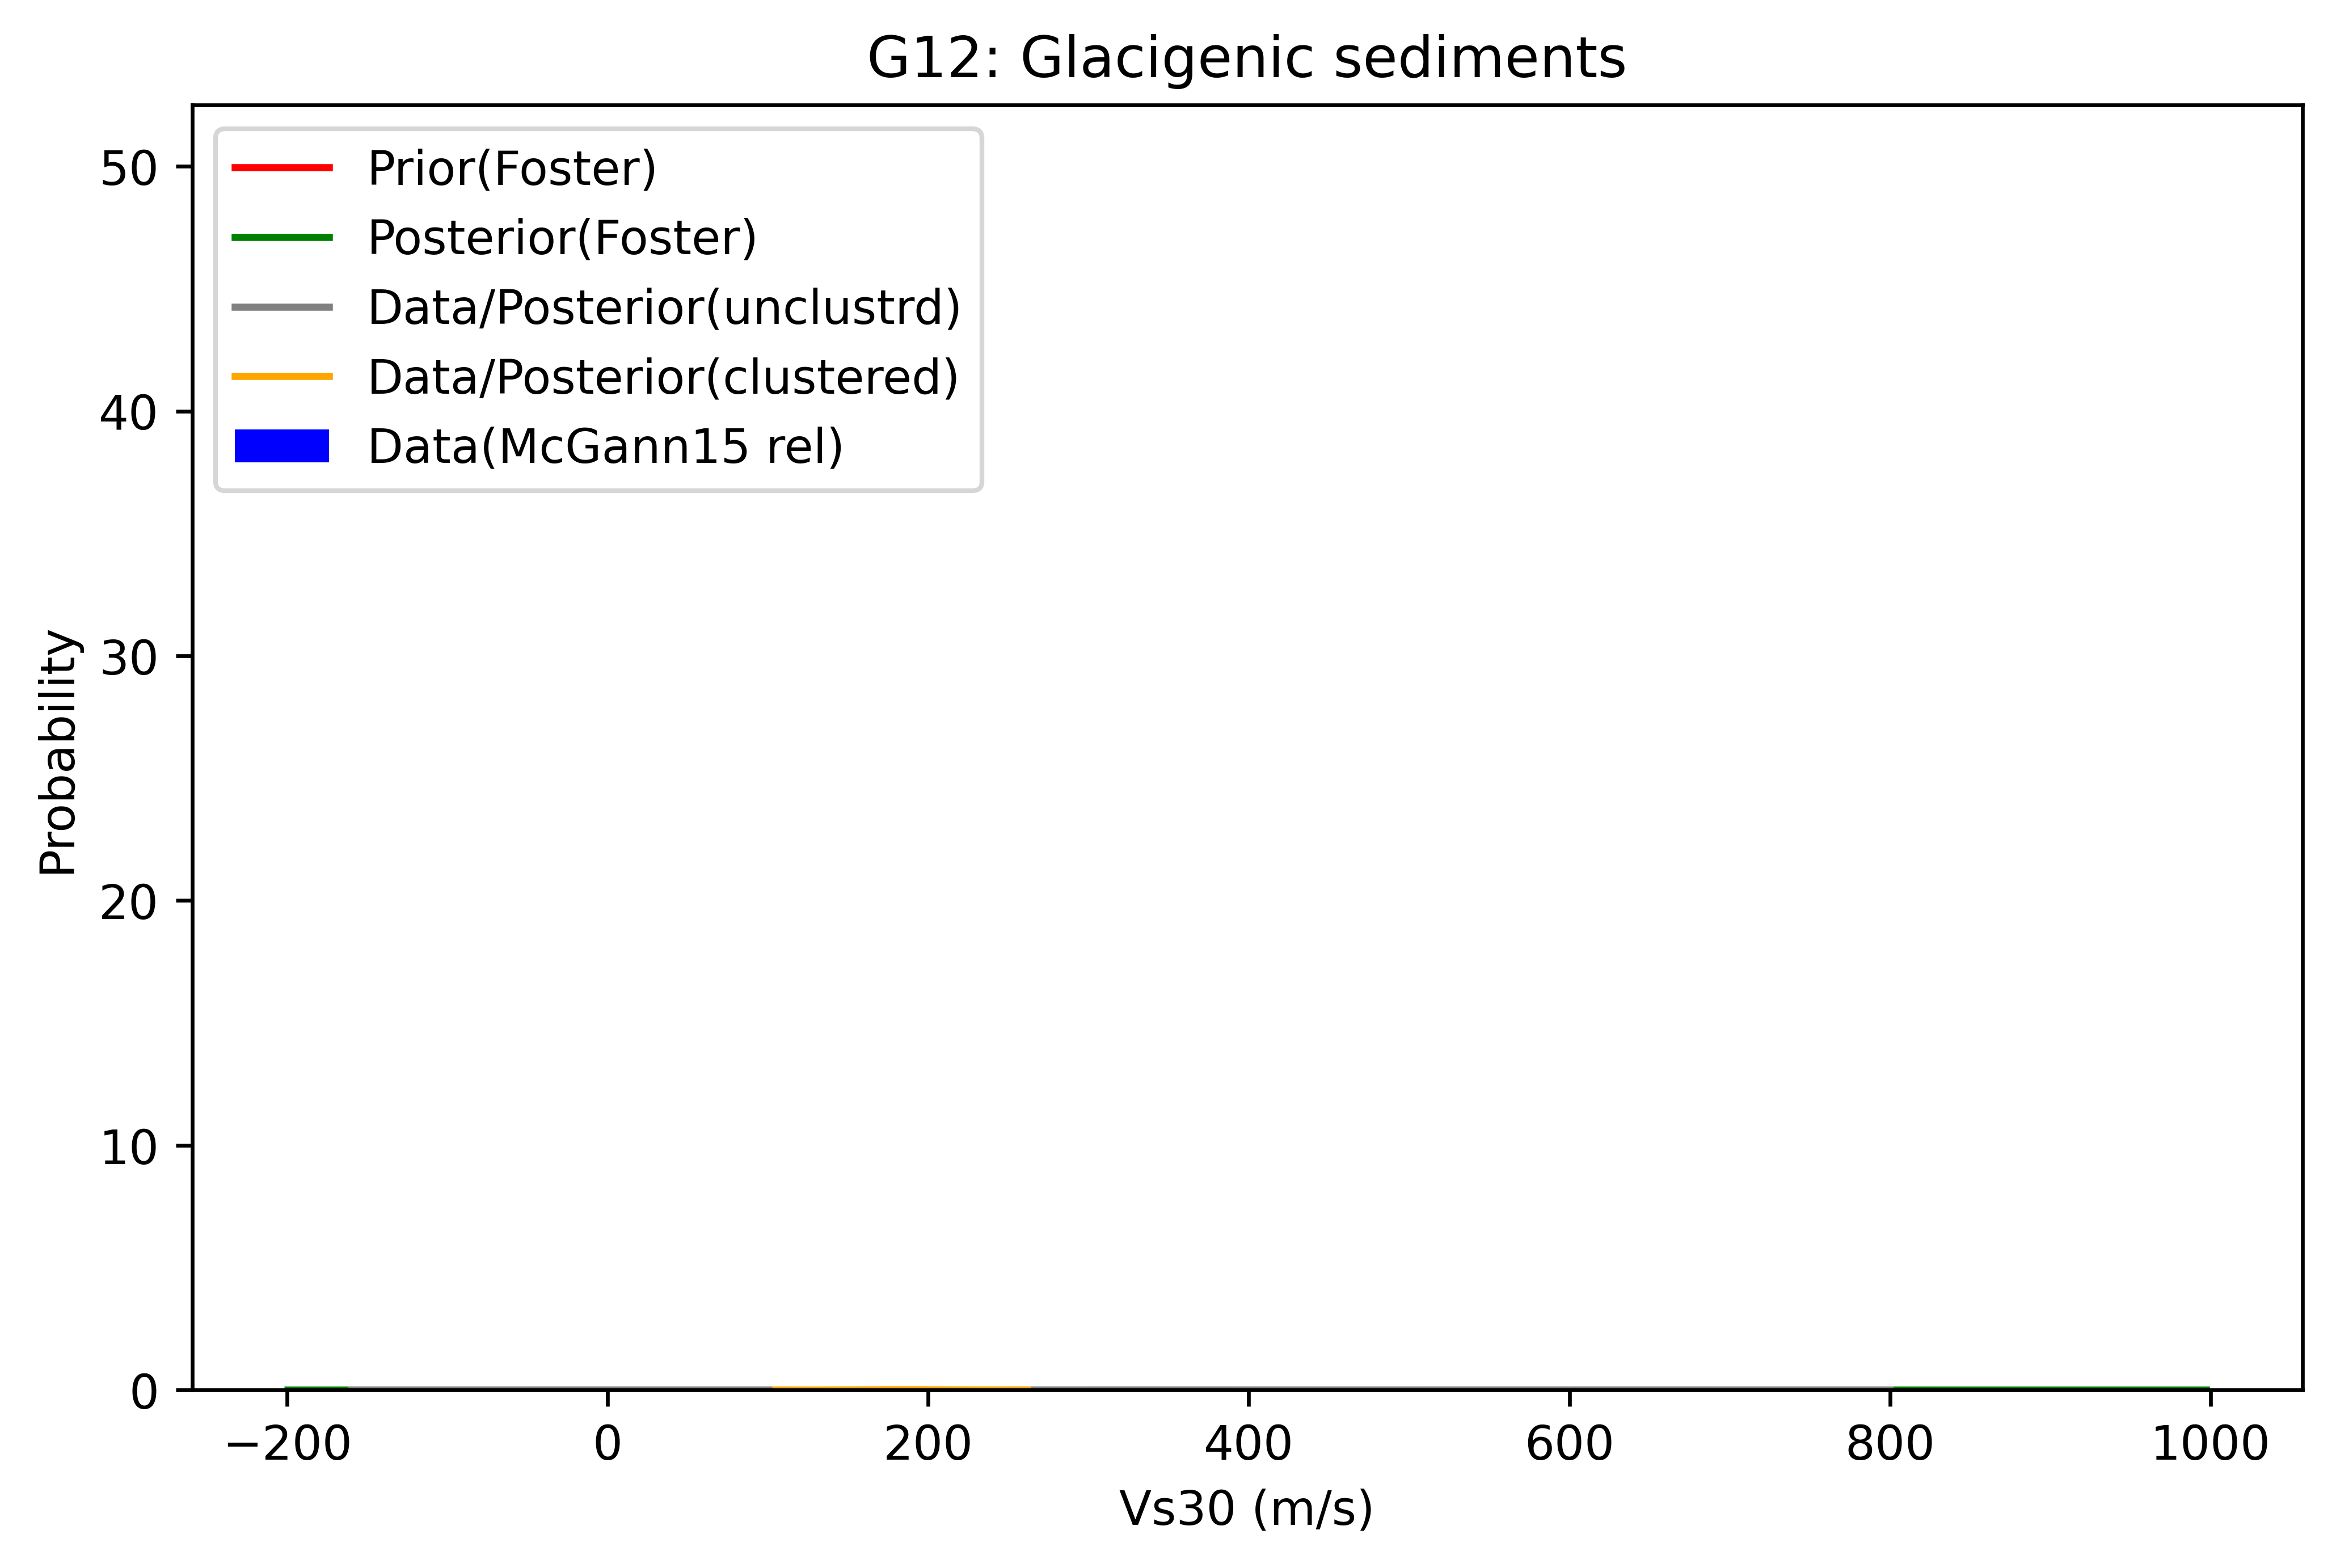

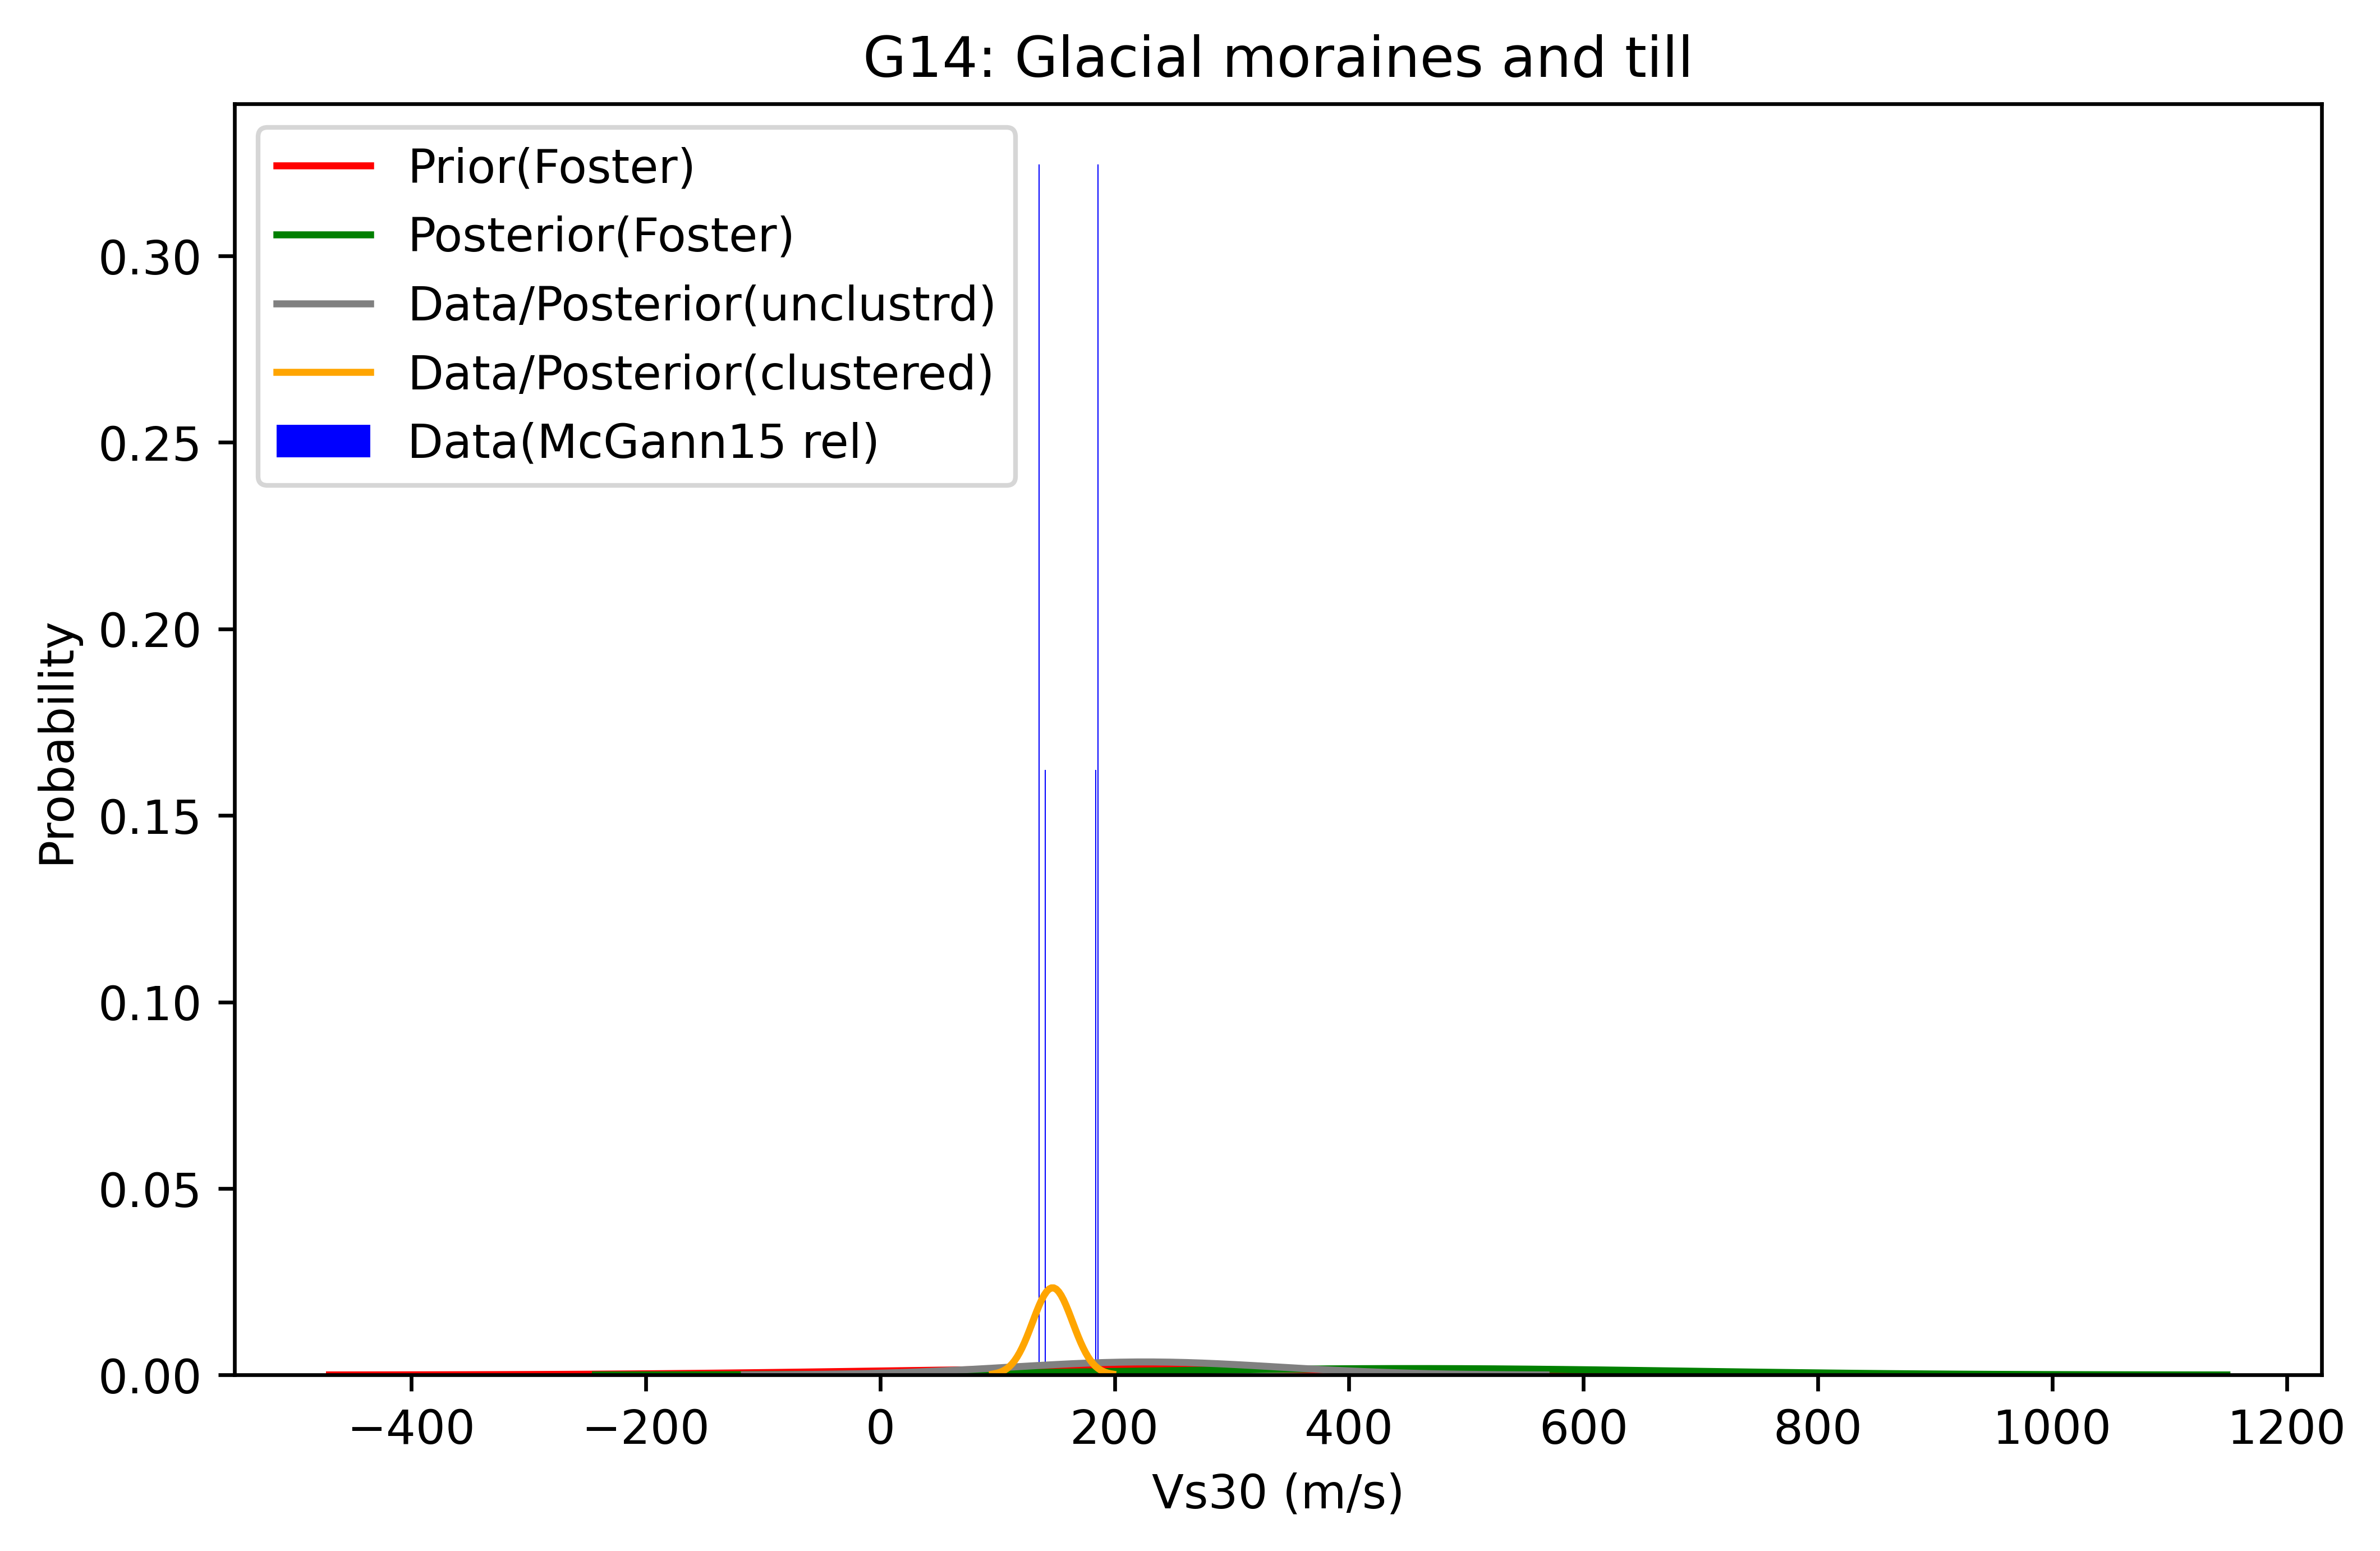

/opt/miniconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


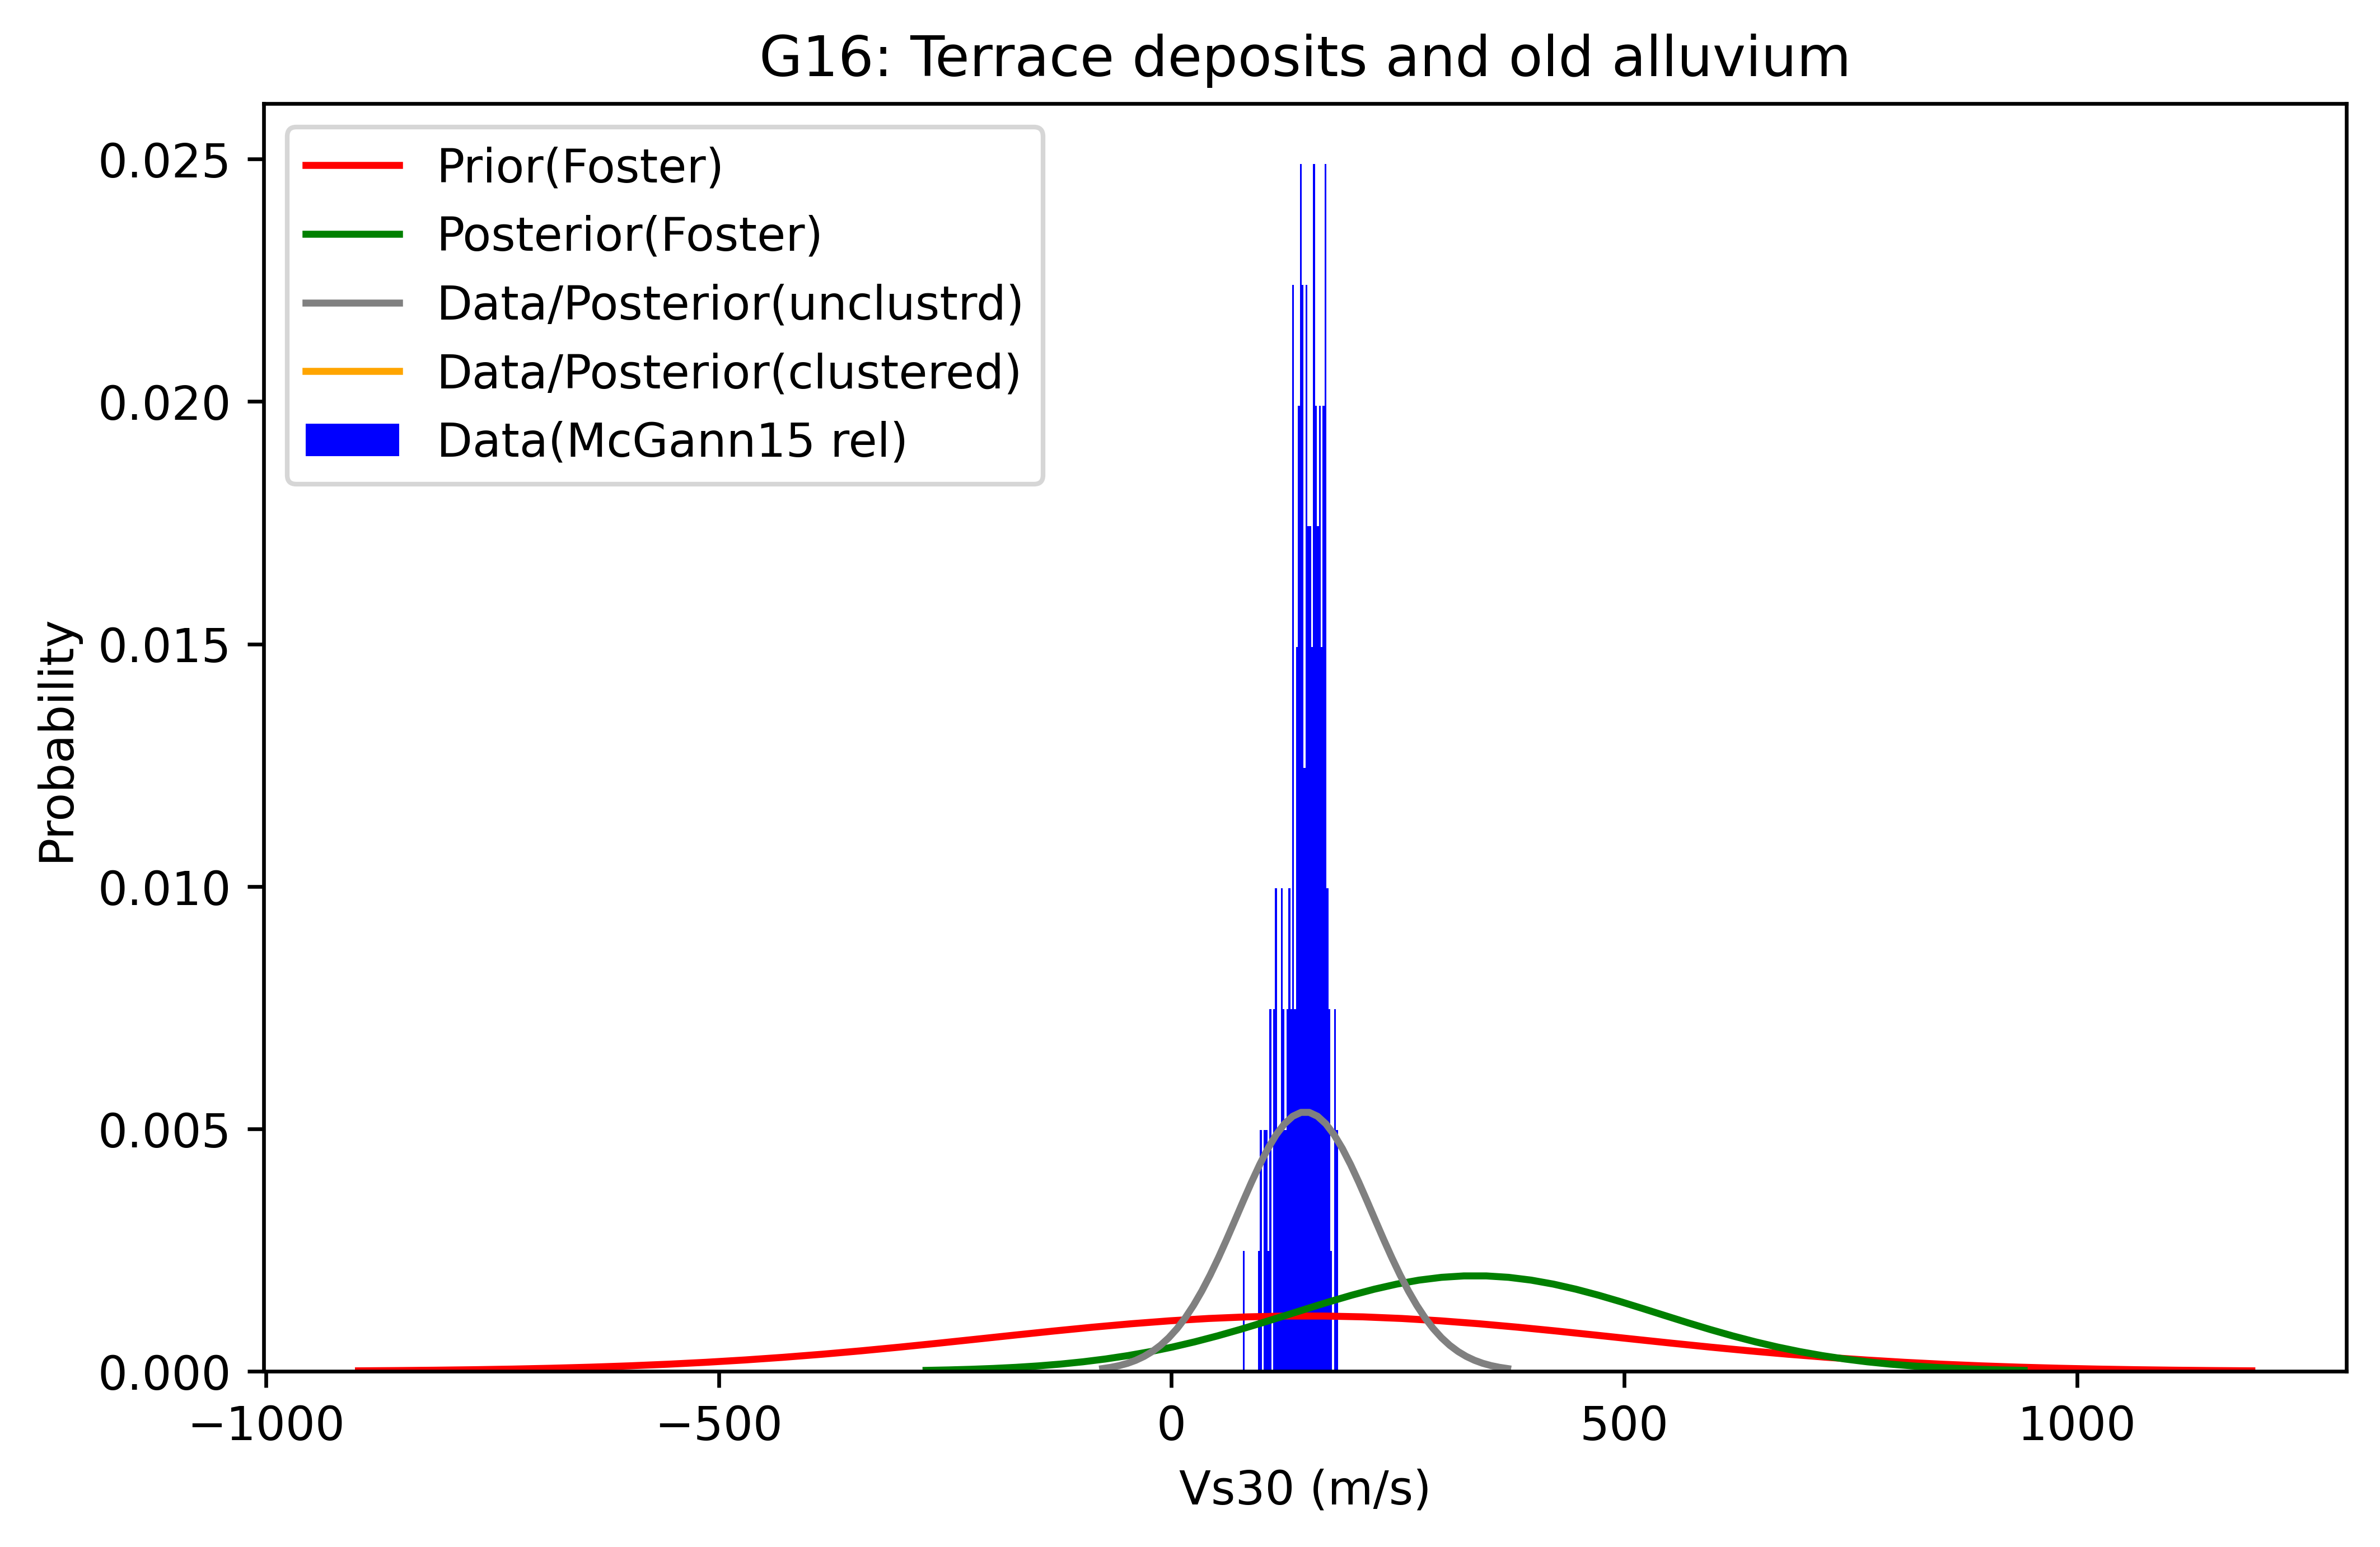

In [23]:
data_dict = {
        "Prior(Foster)": [prior_means,prior_errors,'red'],
        "Posterior(Foster)": [posterior_means,posterior_errors,'green'],
        "Data/Posterior(unclustrd)": [new_posterior_means,new_posterior_errors,"gray"],
        "Data/Posterior(clustered)": [clustered_posterior_means,clustered_posterior_errors,"orange"]
}

for i in range(1,16):
    plot_hist_dist(data_dict,i)


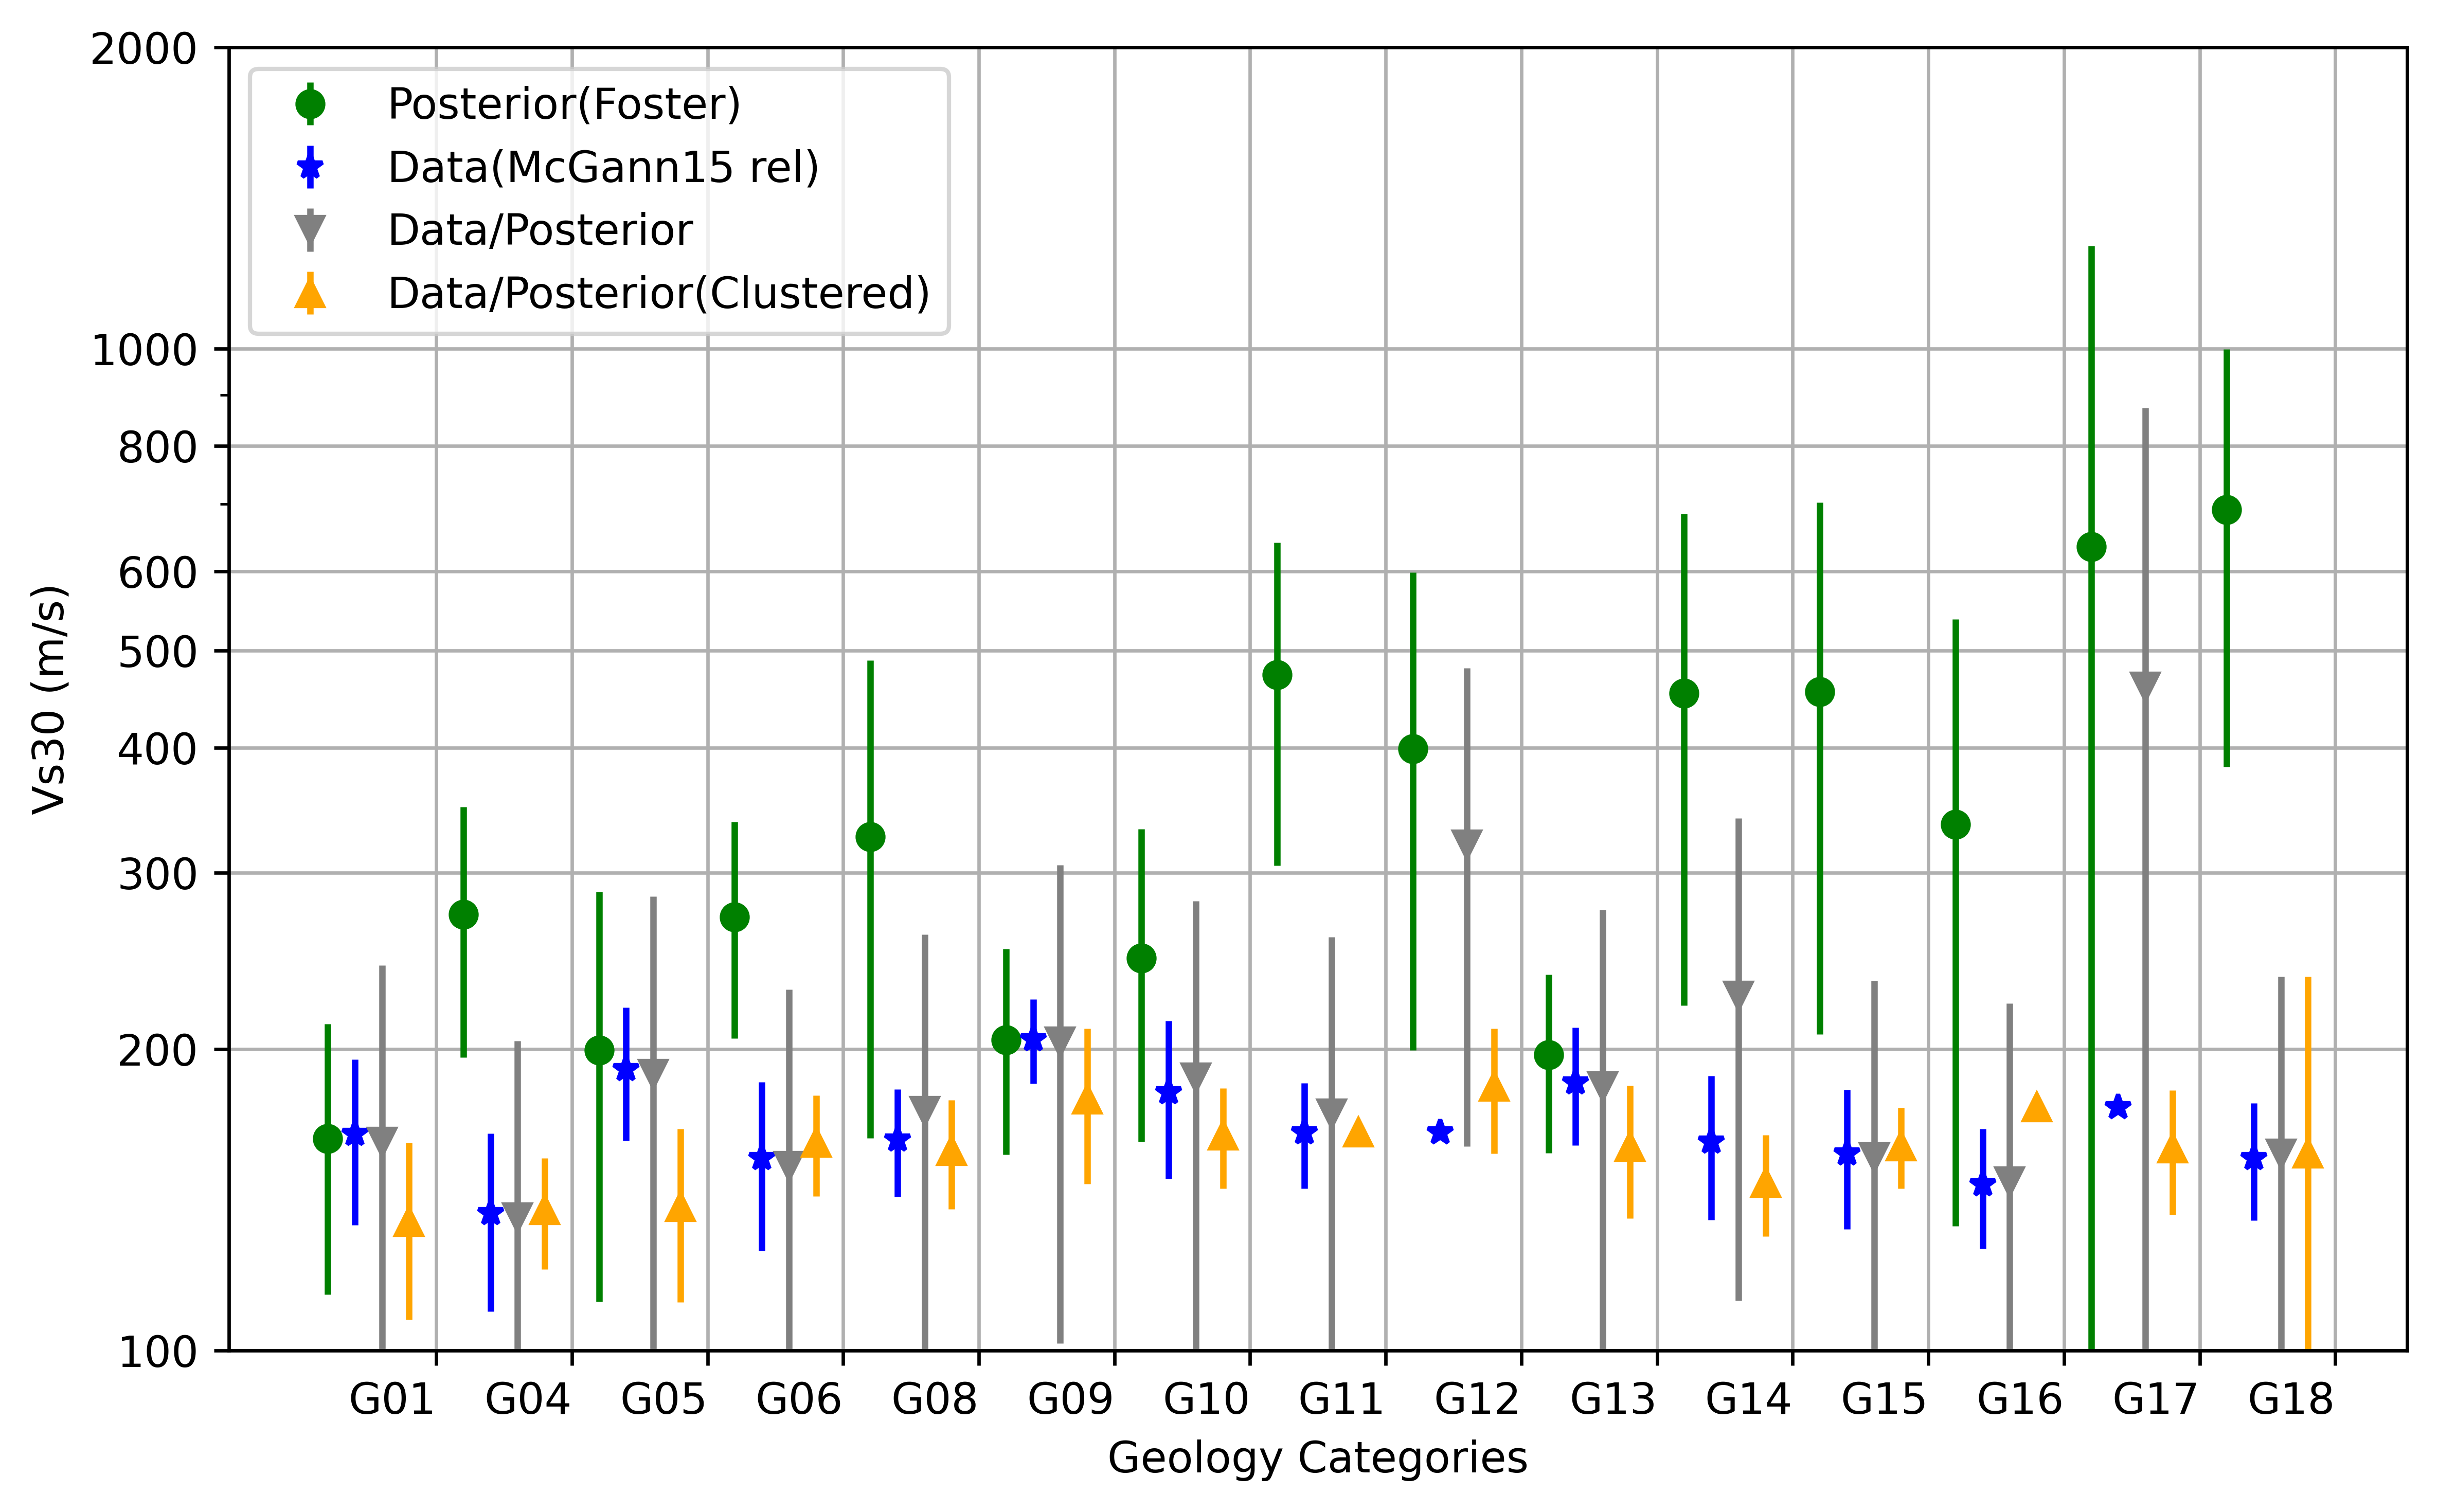

In [24]:
clustered_posterior_means=clustered_posterior.T[0]
clustered_posterior_errors=clustered_posterior.T[1]*clustered_posterior_means

data_dict = {
    #"Prior(Foster)": [prior_means,prior_errors,'x','red'], #this was making the plot too busy
    "Posterior(Foster)": [posterior_means,posterior_errors,'o','green'],
    "Data(McGann15 rel)": [means,errors,"*","blue"],
    "Data/Posterior": [new_posterior_means,new_posterior_errors,"v","grey"],
    "Data/Posterior(Clustered)": [clustered_posterior_means,clustered_posterior_errors,"^","orange"]
}
plot_vs30_for_all_geo_ids(data_dict)